## Start data generation and prep

Define Parameters for the experiment
- True parameters (same as your Data_simulation.ipynb setup_simulation)
- Adjust these based on your specific ground truth setup

In [116]:
k = 3
eta = np.linspace(0, 1, 11)

n_train_per_c = 1000
n_cal_per_c = 100
n_test_per_c = 10000

desired_alpha = 0.05

n_for_initialization = 500    
eta_for_initialization = 0

_, _, means_global, shared_cov_global, class_covs_global = setup_simulation(
    K=k,
    eta=eta_for_initialization,
    n_train=n_for_initialization
)


Plotting the distribution of the data

In [117]:
def plot_simulated_data(X, y, title="Simulated Data"):
    """
    Plots a 2D scatter plot of simulated data colored by class.
    """
    X = np.array(X)
    y = np.array(y)
    classes = np.unique(y)

    plt.figure(figsize=(6, 5))
    for c in classes:
        plt.scatter(X[y == c, 0], X[y == c, 1], label=f"Class {c}", alpha=0.5)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


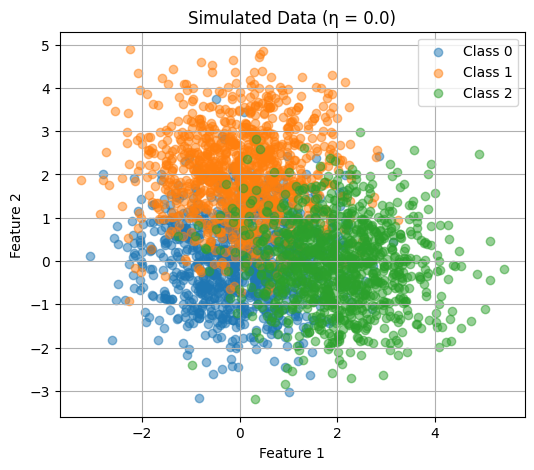

In [118]:
# Generate the full dataset using the generated parameters
X_full, y_full = generate_data(
    n_per_class=n_train_per_c,
    eta=eta_for_initialization,
    K=k,
    means=means_global,
    shared_cov=shared_cov_global,
    class_covs=class_covs_global
)

plot_simulated_data(X_full, y_full, title=f"Simulated Data (η = {eta_for_initialization:.1f})")

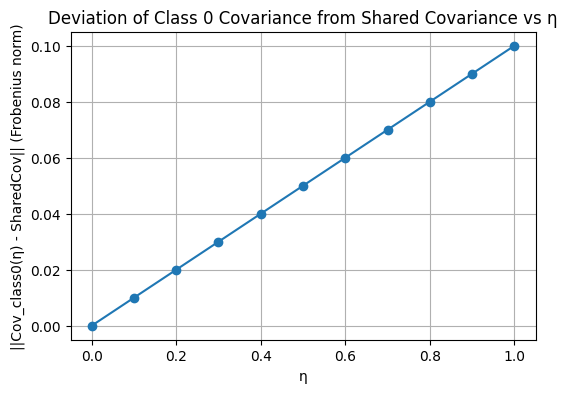

In [119]:
import matplotlib.pyplot as plt

def plot_covariance_change(etas, shared_cov, class_cov):
    cov_diffs = []

    for eta in etas:
        interpolated_cov = (1 - eta) * shared_cov + eta * class_cov
        diff = np.linalg.norm(interpolated_cov - shared_cov)
        cov_diffs.append(diff)

    plt.figure(figsize=(6, 4))
    plt.plot(etas, cov_diffs, marker='o')
    plt.title("Deviation of Class 0 Covariance from Shared Covariance vs η")
    plt.xlabel("η")
    plt.ylabel("||Cov_class0(η) - SharedCov|| (Frobenius norm)")
    plt.grid(True)
    plt.show()

# Run it
plot_covariance_change(
    etas=np.linspace(0, 1, 11),
    shared_cov=shared_cov_global,
    class_cov=class_covs_global[0]
)

In [120]:
print("Frobenius norm ||class_cov - shared_cov||:", np.linalg.norm(class_covs_global[0] - shared_cov_global))
print("Matrices equal?", np.allclose(class_covs_global[0], shared_cov_global))


Frobenius norm ||class_cov - shared_cov||: 0.0999990000049999
Matrices equal? False


In [121]:
def plot_conformity_scores(mapie_model, alpha_list):
    scores = mapie_model.conformity_scores_
    quantiles = mapie_model.quantiles_

    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto", alpha=0.7, label="Conformity Scores")

    for i, q in enumerate(quantiles):
        plt.axvline(x=q, color=f"C{i+1}", linestyle="--", label=f"Quantile α={alpha_list[i]}")
    plt.xlabel("Conformity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Conformity Scores and Quantiles")
    plt.legend()
    plt.grid(True)
    plt.show()


In [122]:
def compute_lda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    if len(np.unique(y_cal)) < 2:
        raise ValueError("Calibration set must contain at least two classes.")

    n_classes = len(np.unique(y_train))

    if n_classes > 2:
        mapie_model = MapieClassifier(estimator=lda, cv="prefit", method="cumulated_score")
        mapie_model.fit(X_cal, y_cal)
        y_pred, y_set = mapie_model.predict(X_test, alpha=alpha, include_last_label=True)

    elif n_classes == 2:
        mapie_model = MapieClassifier(estimator=lda, cv="prefit", method="score")
        mapie_model.fit(X_cal, y_cal)
        y_pred, y_interval = mapie_model.predict(X_test, alpha=alpha, include_last_label=True)

        y_set = []
        for lower, upper in y_interval:
            label_set = []
            if lower <= 0 <= upper:
                label_set.append(0)
            if lower <= 1 <= upper:
                label_set.append(1)
            y_set.append(label_set)
        y_set = np.array(y_set, dtype=object)

    else:
        raise ValueError("Unexpected number of classes.")

    return lda, y_pred, y_set, mapie_model





def compute_qda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha):
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)

    # Defensive check: ensure calibration set has at least two classes
    if len(np.unique(y_cal)) < 2:
        raise ValueError("Calibration set must contain at least two different classes for conformal prediction.")

    n_classes = len(np.unique(y_train))

    if n_classes > 2:
        mapie_model = MapieClassifier(estimator=qda, cv="prefit", method="cumulated_score")
        mapie_model.fit(X_cal, y_cal)
        y_pred, y_set = mapie_model.predict(X_test, alpha=alpha, include_last_label=True)

    elif n_classes == 2:
        mapie_model = MapieClassifier(estimator=qda, cv="prefit", method="score")
        mapie_model.fit(X_cal, y_cal)
        y_pred, y_interval = mapie_model.predict(X_test, alpha=alpha, include_last_label=True)

        y_set = []
        for lower, upper in y_interval:
            label_set = []
            if lower <= 0 <= upper:
                label_set.append(0)
            if lower <= 1 <= upper:
                label_set.append(1)
            y_set.append(label_set)
        y_set = np.array(y_set, dtype=object)

    else:
        raise ValueError("Unexpected number of classes.")

    return qda, y_pred, y_set, mapie_model

from mapie.metrics import classification_coverage_score, classification_mean_width_score

## Main simulation loop normal 

In [123]:
def run_conformal_experiment(
    K,                        # Number of classes
    n_train_per_class,       # Samples per class for training
    n_cal_per_class,         # Samples per class for calibration
    n_test_per_class,        # Samples per class for testing
    means,                   # List of class means
    common_cov,              # Shared covariance matrix
    class_specific_covs,     # List of class-specific covariances
    etas,                    # List of eta values (for blending covariance)
    alpha,               # Desired miscoverage level (e.g. 0.1 → 90% coverage)
    random_seed=42           # Reproducibility
):
    results = []  # To store experiment metrics across η values
    np.random.seed(random_seed)

    for eta_val in etas:
        print(f"\n--- Running for η = {eta_val:.1f} ---")
        total_per_class = n_train_per_class + n_cal_per_class + n_test_per_class

        # Generate full dataset for the current eta
        X_full, y_full = generate_data(
            n_per_class=total_per_class,
            eta=eta_val,
            K=K,
            means=means,
            shared_cov=common_cov,
            class_covs=class_specific_covs
        )

        X_full, y_full = shuffle(X_full, y_full, random_state=random_seed)

        y_full = y_full.astype(int)  # Ensure integer labels

        # Define split indices
        idx_train_end = K * n_train_per_class
        idx_cal_end = idx_train_end + K * n_cal_per_class

        # Slice data into train, calibration, and test sets
        X_train = X_full[:idx_train_end]
        y_train = y_full[:idx_train_end]
        
        X_cal = X_full[idx_train_end:idx_cal_end]
        y_cal = y_full[idx_train_end:idx_cal_end]

        X_test = X_full[idx_cal_end:]
        y_test = y_full[idx_cal_end:]

        print(f"  Training size: {len(X_train)}, Calibration: {len(X_cal)}, Test: {len(X_test)}")

        # Ensure calibration set has at least two classes
        if len(np.unique(y_cal)) < 2:
            print(f"  Skipping eta = {eta_val} due to only one class in calibration set.")
            continue

        # ------------------ LDA ------------------
        lda_model, y_pred_lda, y_set_lda, lda_mapie_model = compute_lda_conformal(
            X_train, y_train, X_cal, y_cal, X_test, alpha
        )

        # Handle prediction set shape (needed if output is 3D, e.g., multiclass singleton dimension)
        if y_set_lda.ndim == 3 and y_set_lda.shape[2] == 1:
            y_set_lda = y_set_lda[:, :, 0]

        # Compute conformal prediction metrics for LDA
        coverage_lda = classification_coverage_score(y_test, y_set_lda)
        sharpness_lda = classification_mean_width_score(y_set_lda)

        # ------------------ QDA ------------------
        qda_model, y_pred_qda, y_set_qda, qda_mapie_model = compute_qda_conformal(
            X_train, y_train, X_cal, y_cal, X_test, alpha
        )

        if y_set_qda.ndim == 3 and y_set_qda.shape[2] == 1:
            y_set_qda = y_set_qda[:, :, 0]

        # Compute conformal prediction metrics for QDA
        coverage_qda = classification_coverage_score(y_test, y_set_qda)
        sharpness_qda = classification_mean_width_score(y_set_qda)

        # ------------------ Probabilistic Scores ------------------
        lda_probs = lda_model.predict_proba(X_test)
        qda_probs = qda_model.predict_proba(X_test)

        log_lda = log_score(lda_probs, y_test)
        brier_lda = brier_score(lda_probs, y_test)
        sph_lda = spherical_score(lda_probs, y_test)

        log_qda = log_score(qda_probs, y_test)
        brier_qda = brier_score(qda_probs, y_test)
        sph_qda = spherical_score(qda_probs, y_test)

        # ------------------ Accuracy ------------------
        lda_accuracy = np.mean(y_pred_lda == y_test)
        qda_accuracy = np.mean(y_pred_qda == y_test)

        # ------------------ Store Results ------------------
        results.append({
            "eta": eta_val,
            "LDA_Coverage": coverage_lda,
            "LDA_Sharpness": sharpness_lda,
            "QDA_Coverage": coverage_qda,
            "QDA_Sharpness": sharpness_qda,
            "LogScore_LDA": log_lda,
            "Brier_LDA": brier_lda,
            "Spherical_LDA": sph_lda,
            "LogScore_QDA": log_qda,
            "Brier_QDA": brier_qda,
            "Spherical_QDA": sph_qda,
            "LDA_Accuracy": lda_accuracy,
            "QDA_Accuracy": qda_accuracy
        })

    # Return full result table and key artifacts for further analysis
    return (
        pd.DataFrame(results),               # Metrics table
        y_cal,                               # Calibration labels
        lda_mapie_model.conformity_scores_,  # LDA conformity scores
        lda_model,                           # Trained LDA model
        lda_mapie_model,                     # Fitted MAPIE wrapper for LDA
        qda_model,                           # Trained QDA model
        qda_mapie_model,                     # Fitted MAPIE wrapper for QDA
        X_test,                              # Test features
        y_test,                              # Test labels
        y_pred_lda,                          # LDA point predictions
        y_pred_qda                           # QDA point predictions
    )


## Main simulation loop Average

In [124]:
def run_conformal_experiment_avg(
    K,
    n_train_per_class,
    n_cal_per_class,
    n_test_per_class,
    means,
    common_cov,
    class_specific_covs,
    etas,
    alpha,
    seeds=range(100)  # Default: 100 seeds
):
    all_results = []

    for seed in seeds:
        print(f"\n Seed {seed}")
        df, *_ = run_conformal_experiment(
            K=K,
            n_train_per_class=n_train_per_class,
            n_cal_per_class=n_cal_per_class,
            n_test_per_class=n_test_per_class,
            means=means,
            common_cov=common_cov,
            class_specific_covs=class_specific_covs,
            etas=etas,  # make sure this is a list!
            alpha=alpha,
            random_seed=seed
        )
        df["seed"] = seed
        all_results.append(df)

    # Concatenate all results
    results_df_avg = pd.concat(all_results)

    # Compute average and std over seeds

    mean_df = results_df_avg.groupby("eta").mean(numeric_only=True).reset_index()
    std_df = results_df_avg.groupby("eta").std(numeric_only=True).reset_index()


    return mean_df, std_df, results_df_avg


## Run the experiment


--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

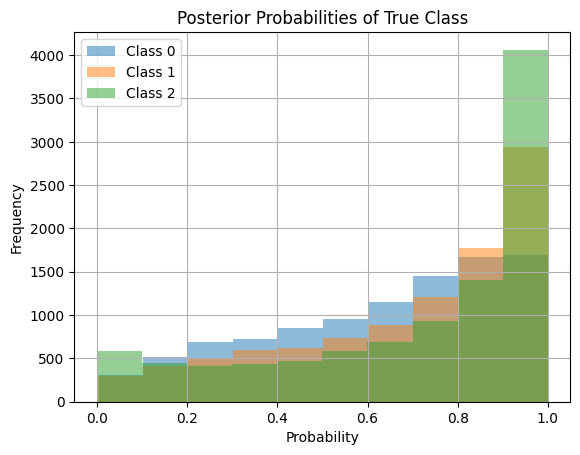


--- Conformal Prediction Results ---
 eta  LDA_Coverage  LDA_Sharpness  QDA_Coverage  QDA_Sharpness  LogScore_LDA  Brier_LDA  Spherical_LDA  LogScore_QDA  Brier_QDA  Spherical_QDA  LDA_Accuracy  QDA_Accuracy
 0.0      0.989467       2.148300      0.990967       2.191833      0.530539   0.310754       0.821275      0.530433   0.310736       0.821284      0.775667      0.775433
 0.1      0.986300       2.064567      0.989633       2.148267      0.527500   0.307950       0.823405      0.527872   0.308070       0.823338      0.780933      0.781067
 0.2      0.986633       2.095733      0.982200       2.013167      0.535572   0.311990       0.820813      0.535275   0.312004       0.820811      0.778867      0.779367
 0.3      0.981300       2.013867      0.982967       2.047433      0.539869   0.313244       0.820007      0.537033   0.312279       0.820559      0.776033      0.777500
 0.4      0.990367       2.232500      0.988167       2.146233      0.547000   0.317498       0.817628     

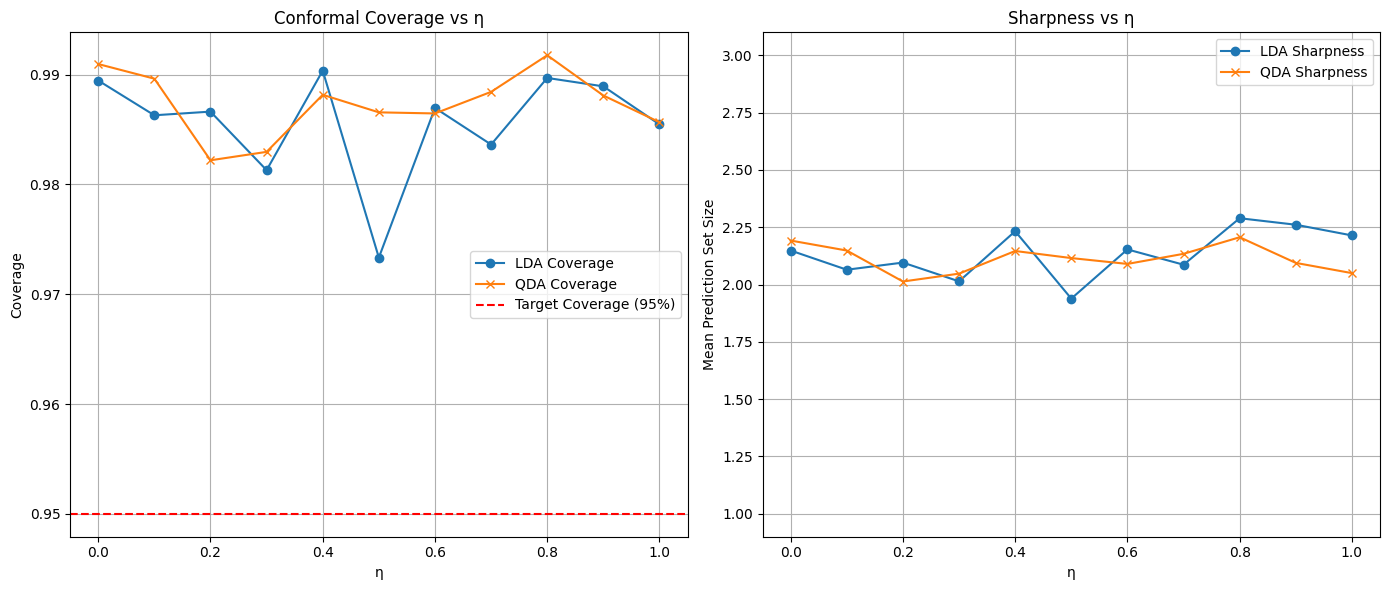

In [125]:
if __name__ == "__main__":
    # === Run conformal experiment with global parameters ===
    results_df, y_cal, lda_scores, lda_model, lda_mapie_model, qda_model, qda_mapie_model, X_test, y_test, y_pred_lda, y_pred_qda = run_conformal_experiment(
        K=k,                                 # Number of classes
        n_train_per_class=n_train_per_c,     # Training samples per class
        n_cal_per_class=n_cal_per_c,         # Calibration samples per class
        n_test_per_class=n_test_per_c,       # Test samples per class
        means=means_global,                  # Class means
        common_cov=shared_cov_global,        # Shared (η = 0) covariance
        class_specific_covs=class_covs_global,  # Class-specific (η = 1) covariances
        etas=eta,                            # List of η values to run
        alpha=desired_alpha,                 # Desired miscoverage (e.g., 0.1 for 90% coverage)
        random_seed=42
    )

    # === Plot histogram of posterior probabilities from LDA ===
    probs = lda_model.predict_proba(X_test)  # Posterior probs for each class

    # Plot probability of the true class for each example
    for i in range(probs.shape[1]):
        plt.hist(probs[y_test == i][:, i], alpha=0.5, label=f"Class {i}")

    plt.title("Posterior Probabilities of True Class")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # === Print result DataFrame neatly ===
    print("\n--- Conformal Prediction Results ---")
    print(results_df.to_string(index=False))  # Avoid cluttering output with index

    # === Plot Coverage and Sharpness vs η ===
    results_df = results_df.sort_values("eta")  # Sort for clean line plots

    plt.figure(figsize=(14, 6))

    # -- Plot 1: Coverage --
    plt.subplot(1, 2, 1)
    plt.plot(results_df['eta'], results_df['LDA_Coverage'], marker='o', label="LDA Coverage")
    plt.plot(results_df['eta'], results_df['QDA_Coverage'], marker='x', label="QDA Coverage")
    plt.axhline(1 - desired_alpha, linestyle="--", color="red", label=f"Target Coverage ({1 - desired_alpha:.0%})")
    plt.title("Conformal Coverage vs η")
    plt.xlabel("η")
    plt.ylabel("Coverage")
    plt.legend()
    plt.grid(True)

    # -- Plot 2: Sharpness --
    plt.subplot(1, 2, 2)
    plt.plot(results_df['eta'], results_df['LDA_Sharpness'], marker='o', label="LDA Sharpness")
    plt.plot(results_df['eta'], results_df['QDA_Sharpness'], marker='x', label="QDA Sharpness")
    plt.title("Sharpness vs η")
    plt.xlabel("η")
    plt.ylabel("Mean Prediction Set Size")
    plt.ylim(0.9, k + 0.1)  # Set bounds to [0.9, K+0.1] to fit within valid set sizes
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


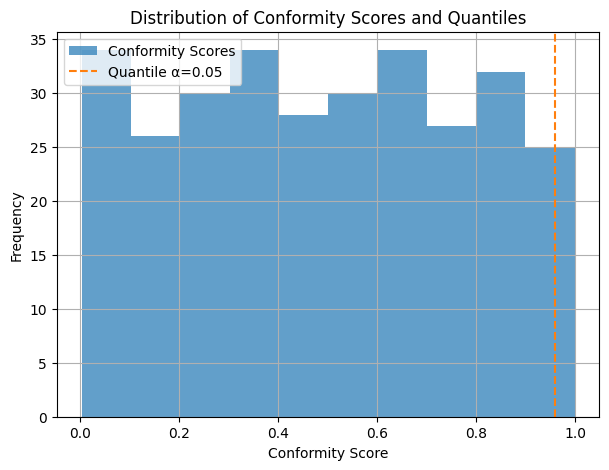

In [126]:
alpha_vals = [desired_alpha]
plot_conformity_scores(lda_mapie_model, alpha_vals)


## Run main average

In [127]:
if __name__ == "__main__":
    # === Run conformal experiment across seeds and average results ===
    mean_df, std_df, results_df_avg = run_conformal_experiment_avg(
        K=k,
        n_train_per_class=n_train_per_c,
        n_cal_per_class=n_cal_per_c,
        n_test_per_class=n_test_per_c,
        means=means_global,
        common_cov=shared_cov_global,
        class_specific_covs=class_covs_global,
        etas=eta,
        alpha=desired_alpha,
        seeds=range(100)  
    )


    # === Print averaged results neatly ===
    print("\n--- Conformal Prediction Results (Averaged over seeds) ---")
    print(mean_df.round(4).to_string(index=False))

    # === Plot Coverage and Sharpness vs η ===
    mean_df = mean_df.sort_values("eta")
    std_df = std_df.sort_values("eta")



 Seed 0

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 1

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 2

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 3

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 4

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 5

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 6

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 7

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 8

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 9

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 10

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 11

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 12

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 13

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 14

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 15

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 16

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 17

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 18

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 19

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 20

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 21

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 22

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 23

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 24

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 25

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 26

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 27

--- Running for η = 0.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 28

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 29

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

 Seed 30

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 31

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 32

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 33

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 34

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 35

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 36

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 37

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 38

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 39

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 40

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 41

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 42

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 43

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 44

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 45

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 46

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 47

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 48

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 49

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 50

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 51

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 52

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 53

--- Running for η = 0.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

 Seed 54

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 55

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 56

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 57

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 58

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 59

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 60

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 61

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 62

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 63

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 64

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 65

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 66

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 67

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 68

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 69

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 70

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 71

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 72

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 73

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 74

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 75

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 76

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

 Seed 77

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 78

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 79

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 80

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 81

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 82

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 83

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 84

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 85

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 86

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 87

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 88

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 89

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 90

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 91

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

 Seed 92

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 93

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 94

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 95

--- Running for η = 0.0 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 96

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 97

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


 Seed 98

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

 Seed 99

--- Running for η = 0.0 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.1 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.2 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.3 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.4 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.5 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.6 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.7 ---
  Training size: 3000, Calibration: 300, Test: 30000


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Running for η = 0.8 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 0.9 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Running for η = 1.0 ---
  Training size: 3000, Calibration: 300, Test: 30000

--- Conformal Prediction Results (Averaged over seeds) ---
 eta  LDA_Coverage  LDA_Sharpness  QDA_Coverage  QDA_Sharpness  LogScore_LDA  Brier_LDA  Spherical_LDA  LogScore_QDA  Brier_QDA  Spherical_QDA  LDA_Accuracy  QDA_Accuracy  seed
 0.0        0.9869         2.0898        0.9866         2.0893        0.5287     0.3090         0.8226        0.5292     0.3091         0.8225        0.7784        0.7783  49.5
 0.1        0.9863         2.0980        0.9864         2.0990        0.5323     0.3104         0.8217        0.5323     0.3104         0.8217        0.7775        0.7775  49.5
 0.2        0.9865         2.1094        0.9863         2.0987        0.5351     0.3116         0.8209        0.5337     0.3112         0.8212        0.7767       

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


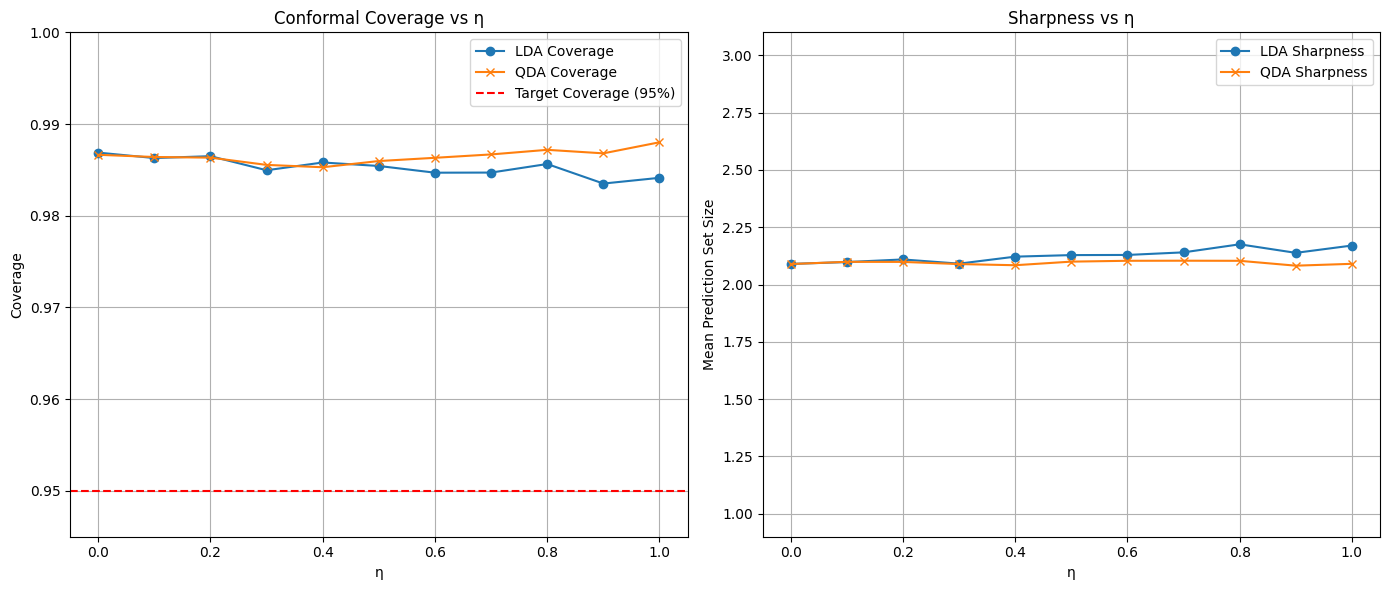

In [128]:
plt.figure(figsize=(14, 6))

# -- Plot 1: Coverage --
plt.subplot(1, 2, 1)
plt.plot(mean_df['eta'], mean_df['LDA_Coverage'], marker='o', label="LDA Coverage")
plt.plot(mean_df['eta'], mean_df['QDA_Coverage'], marker='x', label="QDA Coverage")
plt.axhline(1 - desired_alpha, linestyle="--", color="red", label=f"Target Coverage ({1 - desired_alpha:.0%})")
plt.title("Conformal Coverage vs η")
plt.xlabel("η")
plt.ylabel("Coverage")
plt.ylim(0.945, 1)
plt.legend()
plt.grid(True)

 # -- Plot 2: Sharpness --
plt.subplot(1, 2, 2)
plt.plot(mean_df['eta'], mean_df['LDA_Sharpness'], marker='o', label="LDA Sharpness")
plt.plot(mean_df['eta'], mean_df['QDA_Sharpness'], marker='x', label="QDA Sharpness")
plt.title("Sharpness vs η")
plt.xlabel("η")
plt.ylabel("Mean Prediction Set Size")
plt.ylim(0.9, k + 0.1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [129]:
print("Quantile threshold:", lda_mapie_model.quantiles_)
print("Min, Max score in conformity scores:", 
      np.min(lda_mapie_model.conformity_scores_), 
      np.max(lda_mapie_model.conformity_scores_))


Quantile threshold: [0.95873092]
Min, Max score in conformity scores: 0.0024034389828151426 0.999142077248674


In [130]:
probs = lda_model.predict_proba(X_test[:5])
print(probs)


[[0.81084628 0.16842075 0.02073297]
 [0.36614445 0.3970826  0.23677295]
 [0.07745055 0.9089138  0.01363565]
 [0.07120571 0.01398272 0.91481157]
 [0.06191537 0.92019631 0.01788832]]


In [131]:

y_pred, y_set = qda_mapie_model.predict(X_test, alpha=desired_alpha, include_last_label=True)

print(np.unique([len(s) for s in y_set]))


[3]


In [132]:
print(k)

3


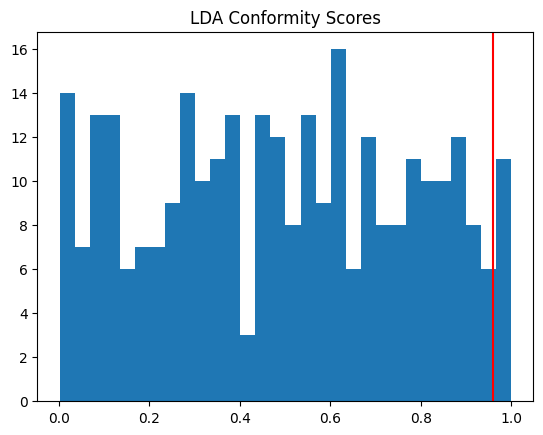

In [133]:
plt.hist(lda_mapie_model.conformity_scores_, bins=30)
plt.axvline(lda_mapie_model.quantiles_[0], color='r')
plt.title("LDA Conformity Scores")
plt.show()


In [134]:
print("Conformity score shape:", lda_mapie_model.conformity_scores_.shape)
print("Some conformity scores:", lda_mapie_model.conformity_scores_[:10])
print("Quantile threshold:", lda_mapie_model.quantiles_)


Conformity score shape: (300, 1)
Some conformity scores: [[0.70046402]
 [0.76618813]
 [0.09417125]
 [0.27340431]
 [0.35293474]
 [0.77606445]
 [0.11838327]
 [0.09003979]
 [0.46090069]
 [0.88609086]]
Quantile threshold: [0.95873092]


print("Conformity score shape:", qda_mapie_model.conformity_scores_.shape)
print("Some conformity scores:", qda_mapie_model.conformity_scores_[:10])
print("Quantile threshold:", qda_mapie_model.quantiles_)


In [135]:
print(results_df[['eta', 'LogScore_LDA', 'Brier_LDA', 'Spherical_LDA',
                  'LogScore_QDA', 'Brier_QDA', 'Spherical_QDA']])


    eta  LogScore_LDA  Brier_LDA  Spherical_LDA  LogScore_QDA  Brier_QDA  \
0   0.0      0.530539   0.310754       0.821275      0.530433   0.310736   
1   0.1      0.527500   0.307950       0.823405      0.527872   0.308070   
2   0.2      0.535572   0.311990       0.820813      0.535275   0.312004   
3   0.3      0.539869   0.313244       0.820007      0.537033   0.312279   
4   0.4      0.547000   0.317498       0.817628      0.539436   0.314548   
5   0.5      0.550899   0.318586       0.816917      0.541248   0.315322   
6   0.6      0.548067   0.317450       0.817601      0.534613   0.312772   
7   0.7      0.547196   0.315894       0.818393      0.531555   0.310922   
8   0.8      0.555380   0.319338       0.816814      0.532292   0.311669   
9   0.9      0.555436   0.320536       0.816435      0.527176   0.310242   
10  1.0      0.559670   0.320389       0.816489      0.523099   0.307206   

    Spherical_QDA  
0        0.821284  
1        0.823338  
2        0.820811  
3      

In [136]:
# After fitting model and predicting probabilities
lda_probs = lda_model.predict_proba(X_test)
qda_probs = qda_model.predict_proba(X_test)

log_lda = log_score(lda_probs, y_test)
brier_lda = brier_score(lda_probs, y_test)
sph_lda = spherical_score(lda_probs, y_test)

log_qda = log_score(qda_probs, y_test)
brier_qda = brier_score(qda_probs, y_test)
sph_qda = spherical_score(qda_probs, y_test)

print("LDA Scores:  Log =", log_lda, ", Brier =", brier_lda, ", Spherical =", sph_lda)
print("QDA Scores:  Log =", log_qda, ", Brier =", brier_qda, ", Spherical =", sph_qda)



LDA Scores:  Log = 0.5596697037880874 , Brier = 0.32038851359332954 , Spherical = 0.8164888588108264
QDA Scores:  Log = 0.5230994687839398 , Brier = 0.3072059109030112 , Spherical = 0.8243433382683967


In [137]:
print(k)

3


## conformal prediction

In [138]:
print("η (Heterogeneity):")
print(results_df['eta'].values)

print("\nLDA Accuracy:")
print(results_df['LDA_Accuracy'].values)

print("\nQDA Accuracy:")
print(results_df['QDA_Accuracy'].values)


η (Heterogeneity):
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

LDA Accuracy:
[0.77566667 0.78093333 0.77886667 0.77603333 0.77396667 0.772
 0.77303333 0.77356667 0.77276667 0.7746     0.7716    ]

QDA Accuracy:
[0.77543333 0.78106667 0.77936667 0.7775     0.776      0.77366667
 0.7761     0.7766     0.77843333 0.77856667 0.78073333]


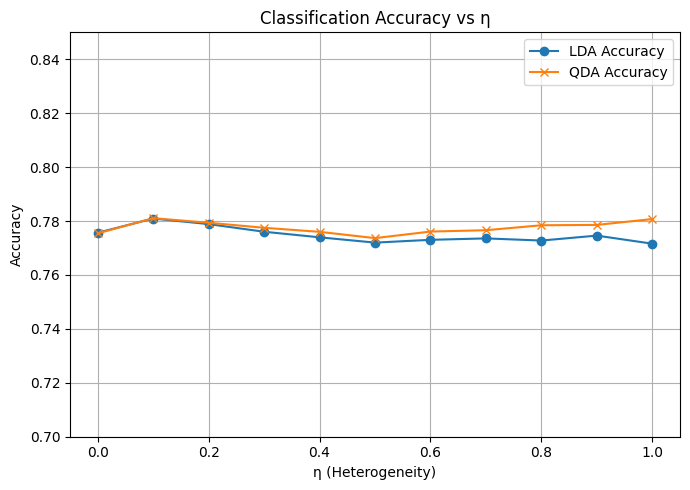

In [139]:
plt.figure(figsize=(7, 5))
plt.plot(results_df['eta'], results_df['LDA_Accuracy'], marker='o', label="LDA Accuracy")
plt.plot(results_df['eta'], results_df['QDA_Accuracy'], marker='x', label="QDA Accuracy")
plt.title("Classification Accuracy vs η")
plt.xlabel("η (Heterogeneity)")
plt.ylabel("Accuracy")
plt.ylim(0.7, 0.85)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [140]:
import matplotlib.pyplot as plt

def plot_conformal_scores(df, model_prefix='LDA'):
    """
    Plot Log Score, Brier Score, and Spherical Score for a given model prefix.

    Args:
        df (pd.DataFrame): DataFrame containing the columns:
            'eta', 'LogScore_{model}', 'Brier_{model}', 'Spherical_{model}'
        model_prefix (str): 'LDA' or 'QDA'
    """
    eta = df['eta']
    log_col = f'LogScore_{model_prefix}'
    brier_col = f'Brier_{model_prefix}'
    sph_col = f'Spherical_{model_prefix}'

    plt.figure(figsize=(8, 5))
    plt.plot(eta, df[log_col], marker='o', label='Log Score')
    plt.plot(eta, df[brier_col], marker='s', label='Brier Score')
    plt.plot(eta, df[sph_col], marker='^', label='Spherical Score')

    plt.title(f'{model_prefix} Conformal Scores vs. η')
    plt.xlabel(r'$\eta$ (class separation heterogeneity)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


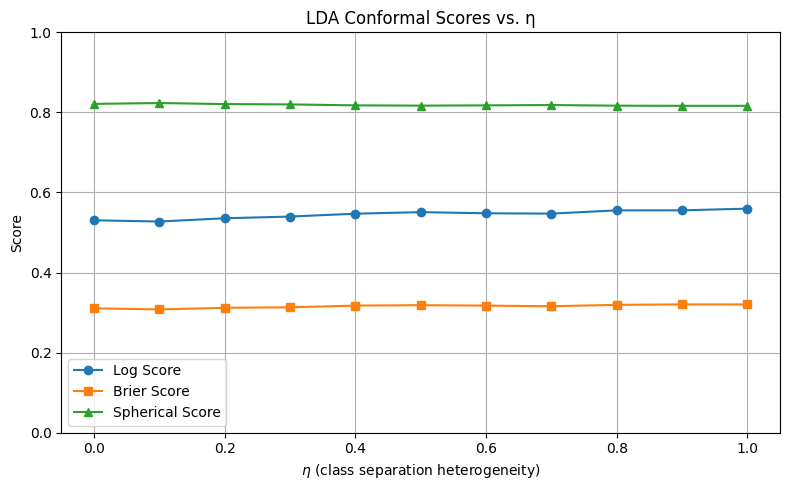

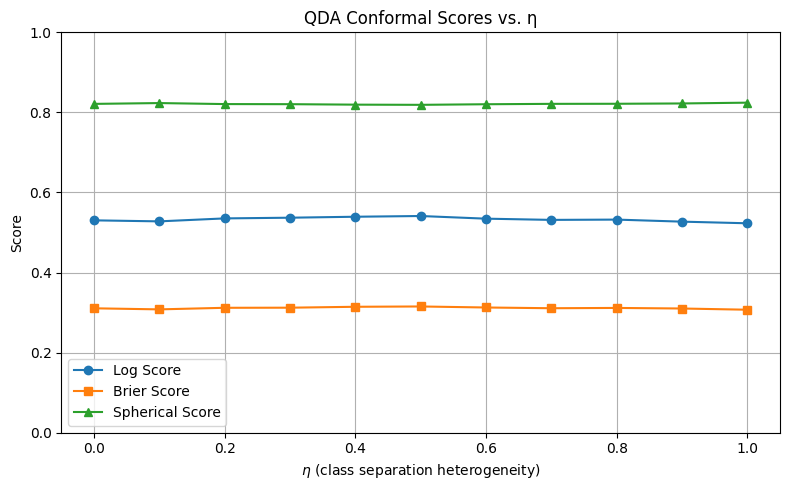

In [141]:
plot_conformal_scores(results_df, model_prefix='LDA')
plot_conformal_scores(results_df, model_prefix='QDA')


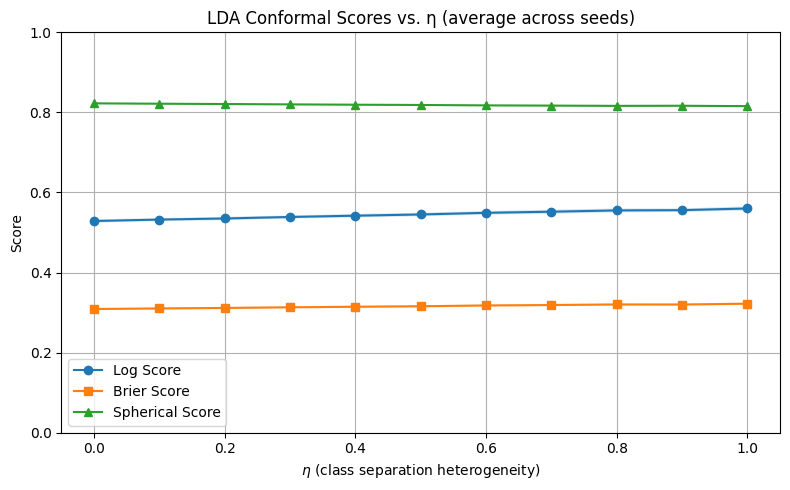

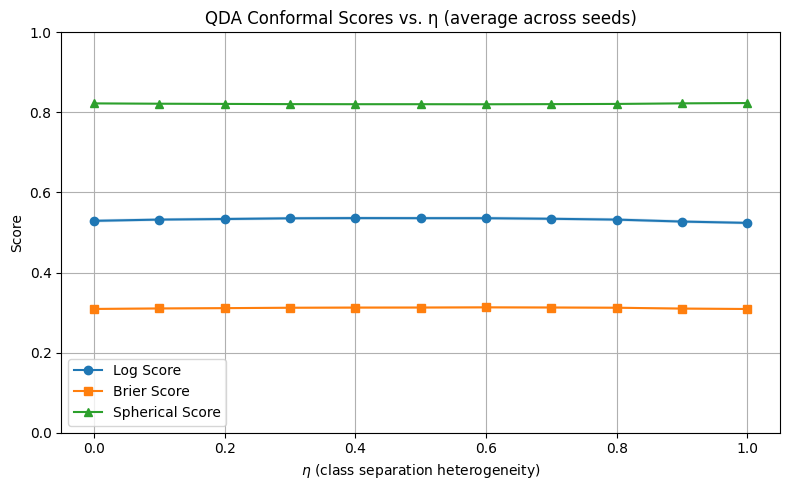

In [142]:
import matplotlib.pyplot as plt

def plot_conformal_scores_across_runs(results_df, model_prefix='LDA'):
    """
    Plot mean Log, Brier, and Spherical scores with error bands across seeds for given model.

    Args:
        results_df (pd.DataFrame): Long-form results with columns:
            'eta', 'LogScore_LDA', 'Brier_LDA', 'Spherical_LDA', etc. across seeds.
        model_prefix (str): 'LDA' or 'QDA'
    """
    grouped = results_df.groupby('eta')
    
    # Compute means and standard deviations
    eta_vals = sorted(grouped.groups.keys())
    log_mean = grouped[f'LogScore_{model_prefix}'].mean()
    log_std  = grouped[f'LogScore_{model_prefix}'].std()

    brier_mean = grouped[f'Brier_{model_prefix}'].mean()
    brier_std  = grouped[f'Brier_{model_prefix}'].std()

    sph_mean = grouped[f'Spherical_{model_prefix}'].mean()
    sph_std  = grouped[f'Spherical_{model_prefix}'].std()

    # Plot
    plt.figure(figsize=(8, 5))

    plt.plot(eta_vals, log_mean, marker='o', label='Log Score')
    plt.fill_between(eta_vals, log_mean - log_std, log_mean + log_std, alpha=0.2)

    plt.plot(eta_vals, brier_mean, marker='s', label='Brier Score')
    plt.fill_between(eta_vals, brier_mean - brier_std, brier_mean + brier_std, alpha=0.2)

    plt.plot(eta_vals, sph_mean, marker='^', label='Spherical Score')
    plt.fill_between(eta_vals, sph_mean - sph_std, sph_mean + sph_std, alpha=0.2)

    plt.title(f'{model_prefix} Conformal Scores vs. η (average across seeds)')
    plt.xlabel(r'$\eta$ (class separation heterogeneity)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_conformal_scores_across_runs(results_df_avg, model_prefix='LDA')
plot_conformal_scores_across_runs(results_df_avg, model_prefix='QDA')


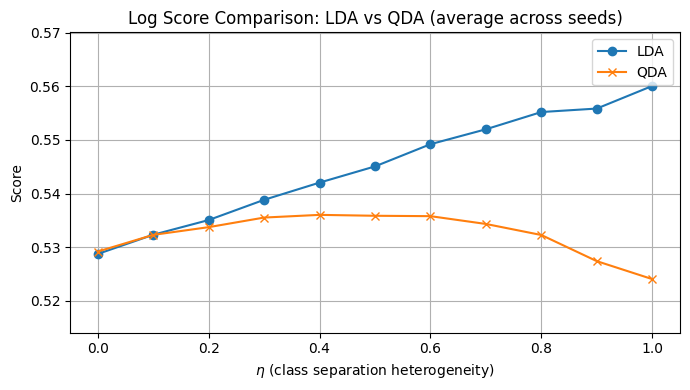

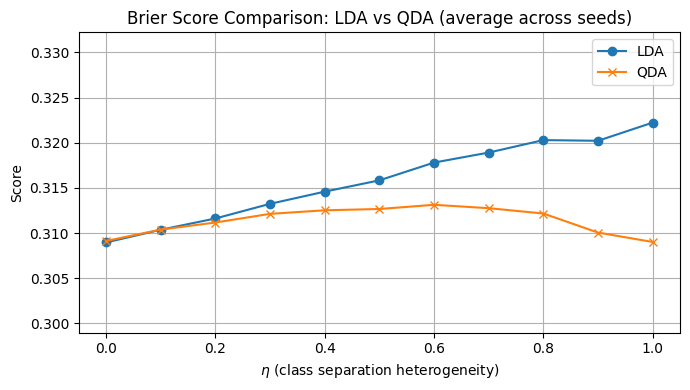

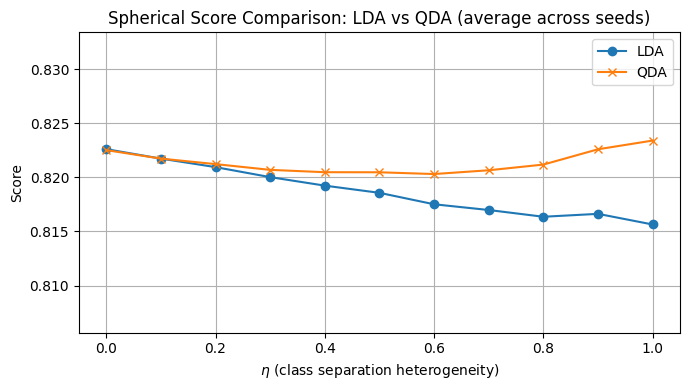

In [143]:
import matplotlib.pyplot as plt

def plot_score_comparison(results_df):
    """
    Plot mean Log, Brier, and Spherical scores comparing LDA and QDA across η values,
    with dynamic y-axis limits based on each score range.

    Args:
        results_df (pd.DataFrame): Must contain 'eta', and score columns for both LDA and QDA:
                                   ['LogScore_LDA', 'LogScore_QDA', 'Brier_LDA', 'Brier_QDA',
                                    'Spherical_LDA', 'Spherical_QDA']
    """
    grouped = results_df.groupby('eta')
    eta_vals = sorted(grouped.groups.keys())

    scores = {
        "Log Score": ("LogScore_LDA", "LogScore_QDA"),
        "Brier Score": ("Brier_LDA", "Brier_QDA"),
        "Spherical Score": ("Spherical_LDA", "Spherical_QDA")
    }

    for title, (lda_col, qda_col) in scores.items():
        lda_mean = grouped[lda_col].mean()
        qda_mean = grouped[qda_col].mean()

        # Determine y-axis limits based on data range
        all_vals = pd.concat([lda_mean, qda_mean])
        y_min = all_vals.min() - 0.01
        y_max = all_vals.max() + 0.01

        plt.figure(figsize=(7, 4))
        plt.plot(eta_vals, lda_mean, marker='o', label='LDA')
        plt.plot(eta_vals, qda_mean, marker='x', label='QDA')
        plt.title(f'{title} Comparison: LDA vs QDA (average across seeds)')
        plt.xlabel(r'$\eta$ (class separation heterogeneity)')
        plt.ylabel('Score')
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_score_comparison(results_df_avg)


In [144]:
"""import numpy as np
import pandas as pd
import random

# --- Revised equilibrium check ---
def check_equilibrium(lda_acc, qda_acc, margin=0.02):
    lda_acc = np.array(lda_acc)
    qda_acc = np.array(qda_acc)

    # Condition 1: LDA better at η = 0
    if lda_acc[0] <= qda_acc[0] + margin:
        return False

    # Condition 2: QDA generally improves
    if np.mean(np.diff(qda_acc)) <= -margin:
        return False

    # Condition 3: LDA doesn't improve
    if np.mean(np.diff(lda_acc)) > margin:
        return False

    # Condition 4: Once QDA is better, it stays better (within margin)
    diff = qda_acc - lda_acc
    cross_idx = np.where(diff > margin)[0]
    if len(cross_idx) == 0:
        return False
    first_cross = cross_idx[0]
    if not np.all(diff[first_cross:] > -margin):
        return False

    return True



# --- Optional scoring ---
def score_config(results_df):
    qda_high = results_df[results_df["eta"] >= 0.6]["QDA_Accuracy"].mean()
    lda_low = results_df[results_df["eta"] <= 0.4]["LDA_Accuracy"].mean()
    sharpness_bonus = results_df["LDA_Sharpness"].mean() - results_df["QDA_Sharpness"].mean()
    return lda_low + qda_high + sharpness_bonus

# --- Parameter ranges ---
train_vals = range(50, 500, 10)
cal_vals = range(10, 200, 10)
test_vals = range(50, 1000, 25)
eta_range = np.linspace(0, 1, 11)

print("🔍 Searching for LDA-to-QDA crossover equilibrium...")

MAX_ATTEMPTS = 5000
attempt = 0

while attempt < MAX_ATTEMPTS:
    attempt += 1
    train = random.choice(train_vals)
    cal = random.choice(cal_vals)
    test = random.choice(test_vals)

    try:
        results_df, *_ = run_conformal_experiment(
            K=3,
            n_train_per_class=train,
            n_cal_per_class=cal,
            n_test_per_class=test,
            means=means_global,
            common_cov=shared_cov_global,
            class_specific_covs=class_covs_global,
            etas=eta_range,
            alpha=desired_alpha
        )

        lda_acc = results_df["LDA_Accuracy"].values
        qda_acc = results_df["QDA_Accuracy"].values

        if len(lda_acc) == 11 and check_equilibrium(lda_acc, qda_acc):
            score = score_config(results_df)
            print(f"\n✅ Found equilibrium after {attempt} tries!")
            print(f"Train={train}, Cal={cal}, Test={test}, Score={score:.3f}")
            print("η values:         ", results_df['eta'].values)
            print("LDA Accuracy:     ", np.round(lda_acc, 3))
            print("QDA Accuracy:     ", np.round(qda_acc, 3))
            break

    except Exception as e:
        print(f"⚠️ Skipped (train={train}, cal={cal}, test={test}) due to error: {e}")

else:
    print(f"\n❌ No equilibrium found after {MAX_ATTEMPTS} attempts.")
"""

'import numpy as np\nimport pandas as pd\nimport random\n\n# --- Revised equilibrium check ---\ndef check_equilibrium(lda_acc, qda_acc, margin=0.02):\n    lda_acc = np.array(lda_acc)\n    qda_acc = np.array(qda_acc)\n\n    # Condition 1: LDA better at η = 0\n    if lda_acc[0] <= qda_acc[0] + margin:\n        return False\n\n    # Condition 2: QDA generally improves\n    if np.mean(np.diff(qda_acc)) <= -margin:\n        return False\n\n    # Condition 3: LDA doesn\'t improve\n    if np.mean(np.diff(lda_acc)) > margin:\n        return False\n\n    # Condition 4: Once QDA is better, it stays better (within margin)\n    diff = qda_acc - lda_acc\n    cross_idx = np.where(diff > margin)[0]\n    if len(cross_idx) == 0:\n        return False\n    first_cross = cross_idx[0]\n    if not np.all(diff[first_cross:] > -margin):\n        return False\n\n    return True\n\n\n\n# --- Optional scoring ---\ndef score_config(results_df):\n    qda_high = results_df[results_df["eta"] >= 0.6]["QDA_Accuracy"]

## Data Size

In [145]:
def run_data_size_experiment(
    eta_values,              
    total_sizes,           
    train_ratio=0.5,
    cal_ratio=0.25,
    test_ratio=0.25,
    K=3,
    means=None,
    shared_cov=None,
    class_covs=None,
    alpha=0.1,
    random_seed=42
):
    all_results = []
    np.random.seed(random_seed)

    for total_per_class in total_sizes:
        n_train = int(total_per_class * train_ratio)
        n_cal = int(total_per_class * cal_ratio)
        n_test = int(total_per_class * test_ratio)

        for eta_val in eta_values:
            print(f"\n--- Size: {total_per_class} per class | η = {eta_val:.2f} ---")

            X_full, y_full = generate_data(
                n_per_class=total_per_class,
                eta=eta_val,
                K=K,
                means=means,
                shared_cov=shared_cov,
                class_covs=class_covs
            )
            y_full = y_full.astype(int)

            X_train, y_train = [], []
            X_cal, y_cal = [], []
            X_test, y_test = [], []

            for k in range(K):
                start = k * total_per_class
                end = (k + 1) * total_per_class
                X_k = X_full[start:end]
                y_k = y_full[start:end]

                X_train.append(X_k[:n_train])
                y_train.append(y_k[:n_train])

                X_cal.append(X_k[n_train:n_train + n_cal])
                y_cal.append(y_k[n_train:n_train + n_cal])

                X_test.append(X_k[n_train + n_cal:])
                y_test.append(y_k[n_train + n_cal:])

            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train).ravel()
            X_cal = np.vstack(X_cal)
            y_cal = np.concatenate(y_cal).ravel()
            X_test = np.vstack(X_test)
            y_test = np.concatenate(y_test).ravel()

            if len(np.unique(y_train)) < K:
                print(f"  Skipped: Only {len(np.unique(y_train))} class(es) in training for η = {eta_val}")
                continue

            if len(np.unique(y_cal)) < 2:
                print(f"  Skipped: Only one class in calibration for η = {eta_val}")
                continue

            lda_model, y_pred_lda, y_set_lda, lda_mapie = compute_lda_conformal(
                X_train, y_train, X_cal, y_cal, X_test, alpha
            )
            if y_set_lda.ndim == 3 and y_set_lda.shape[2] == 1:
                y_set_lda = y_set_lda[:, :, 0]

            lda_coverage = classification_coverage_score(y_test, y_set_lda)
            lda_sharpness = classification_mean_width_score(y_set_lda)
            lda_probs = lda_model.predict_proba(X_test)
            lda_acc = np.mean(y_pred_lda == y_test)

            qda_model, y_pred_qda, y_set_qda, qda_mapie = compute_qda_conformal(
                X_train, y_train, X_cal, y_cal, X_test, alpha
            )
            if y_set_qda.ndim == 3 and y_set_qda.shape[2] == 1:
                y_set_qda = y_set_qda[:, :, 0]

            qda_coverage = classification_coverage_score(y_test, y_set_qda)
            qda_sharpness = classification_mean_width_score(y_set_qda)
            qda_probs = qda_model.predict_proba(X_test)
            qda_acc = np.mean(y_pred_qda == y_test)

            all_results.append({
                "TotalPerClass": total_per_class,
                "eta": eta_val,
                "LDA_Accuracy": lda_acc,
                "LDA_Coverage": lda_coverage,
                "LDA_Sharpness": lda_sharpness,
                "QDA_Accuracy": qda_acc,
                "QDA_Coverage": qda_coverage,
                "QDA_Sharpness": qda_sharpness
            })

    return pd.DataFrame(all_results)


In [146]:
print(k)

if __name__ == "__main__":
    eta_vals = [0.0, 0.25, 0.5, 0.75, 1.0]     
    total_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300,1400, 1500]  
    alpha = desired_alpha
    K = k
    
    results_df_size = run_data_size_experiment(
        eta_values=eta_vals,
        total_sizes=total_sizes,
        train_ratio=0.5,
        cal_ratio=0.25,
        test_ratio=0.25,
        K=K,
        means=means_global,
        shared_cov=shared_cov_global,
        class_covs=class_covs_global,
        alpha=alpha
    )

3

--- Size: 100 per class | η = 0.00 ---

--- Size: 100 per class | η = 0.25 ---

--- Size: 100 per class | η = 0.50 ---

--- Size: 100 per class | η = 0.75 ---

--- Size: 100 per class | η = 1.00 ---

--- Size: 200 per class | η = 0.00 ---

--- Size: 200 per class | η = 0.25 ---

--- Size: 200 per class | η = 0.50 ---

--- Size: 200 per class | η = 0.75 ---

--- Size: 200 per class | η = 1.00 ---

--- Size: 300 per class | η = 0.00 ---

--- Size: 300 per class | η = 0.25 ---

--- Size: 300 per class | η = 0.50 ---

--- Size: 300 per class | η = 0.75 ---

--- Size: 300 per class | η = 1.00 ---

--- Size: 400 per class | η = 0.00 ---

--- Size: 400 per class | η = 0.25 ---

--- Size: 400 per class | η = 0.50 ---

--- Size: 400 per class | η = 0.75 ---

--- Size: 400 per class | η = 1.00 ---

--- Size: 500 per class | η = 0.00 ---

--- Size: 500 per class | η = 0.25 ---

--- Size: 500 per class | η = 0.50 ---

--- Size: 500 per class | η = 0.75 ---

--- Size: 500 per class | η = 1.00 --

/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- Size: 1500 per class | η = 0.00 ---

--- Size: 1500 per class | η = 0.25 ---

--- Size: 1500 per class | η = 0.50 ---

--- Size: 1500 per class | η = 0.75 ---

--- Size: 1500 per class | η = 1.00 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

In [147]:
def plot_metric_by_size(df, metric="Accuracy", title="", ylabel=""):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    # Plot LDA
    sns.lineplot(
        data=df,
        x="TotalPerClass",
        y=f"LDA_{metric}",
        hue="eta",
        style="eta",
        markers=True,
        dashes=False,
        legend="brief"
    )

    # Plot QDA
    sns.lineplot(
        data=df,
        x="TotalPerClass",
        y=f"QDA_{metric}",
        hue="eta",
        style="eta",
        markers=True,
        dashes=True,
        legend=False  # already shown above
    )

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Data Set Size per Class")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import os
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_by_eta(df, metric="Accuracy", title_prefix="", ylabel="", save_dir=None, dpi=300):
    """
    Plot LDA vs QDA performance per eta level for the given metric,
    and optionally save each figure with eta in the filename.
    
    Parameters:
        df (pd.DataFrame): Results DataFrame
        metric (str): "Accuracy", "Coverage", or "Sharpness"
        title_prefix (str): Title prefix for each plot
        ylabel (str): Y-axis label
        save_dir (str or None): Folder to save plots, or None to just display
        dpi (int): Resolution for saved figures
    """
    eta_values = sorted(df["eta"].unique())

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for eta_val in eta_values:
        subset = df[df["eta"] == eta_val]
        plt.figure(figsize=(8, 5))

        sns.lineplot(x="TotalPerClass", y=f"LDA_{metric}", data=subset, marker="o", label="LDA")
        sns.lineplot(x="TotalPerClass", y=f"QDA_{metric}", data=subset, marker="s", label="QDA")

        plt.title(f"{title_prefix} (η = {eta_val:.2f})")
        plt.ylabel(ylabel)
        plt.xlabel("Data Set Size per Class")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_dir is not None:
            filename = f"{metric}_eta={eta_val:.2f}.png"
            path = os.path.join(save_dir, filename)
            plt.savefig(path, dpi=dpi)
            print(f"Saved: {path}")

        plt.show()



In [148]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metric_by_eta(df, metric="Accuracy", title_prefix="", ylabel="", save_dir=None, dpi=300):
    """
    Plot LDA vs QDA performance for eta = 0, 0.5, 1 for the given metric.

    Parameters:
        df (pd.DataFrame): Results DataFrame
        metric (str): "Accuracy", "Coverage", or "Sharpness"
        title_prefix (str): Title prefix for each plot
        ylabel (str): Y-axis label
        save_dir (str or None): Folder to save plots, or None to just display
        dpi (int): Resolution for saved figures
    """
    target_etas = [0.0, 0.5, 1.0]

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for eta_val in target_etas:
        subset = df[df["eta"] == eta_val]
        if subset.empty:
            continue  # Skip if no data for this eta

        plt.figure(figsize=(8, 5))

        sns.lineplot(x="TotalPerClass", y=f"LDA_{metric}", data=subset, marker="o", label="LDA")
        sns.lineplot(x="TotalPerClass", y=f"QDA_{metric}", data=subset, marker="s", label="QDA")

        plt.title(f"{title_prefix} (η = {eta_val:.2f})")
        plt.ylabel(ylabel)
        plt.xlabel("Data Set Size per Class")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save_dir is not None:
            filename = f"{metric}_eta={eta_val:.2f}.png"
            path = os.path.join(save_dir, filename)
            plt.savefig(path, dpi=dpi)
            print(f"Saved: {path}")

        plt.show()


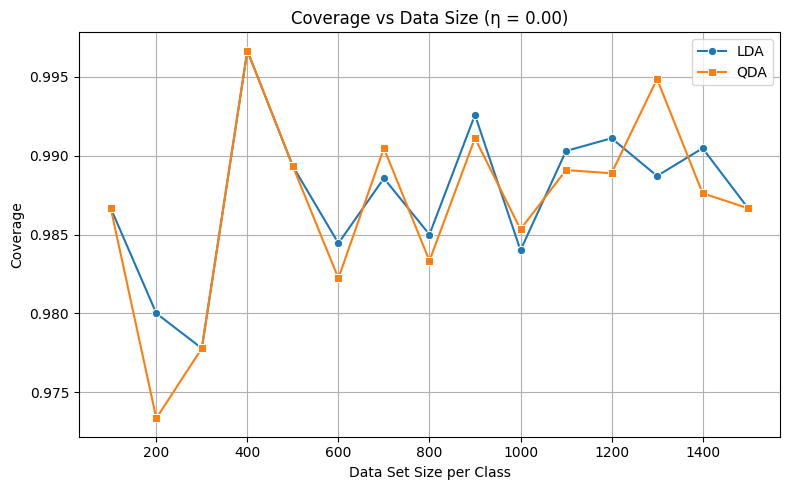

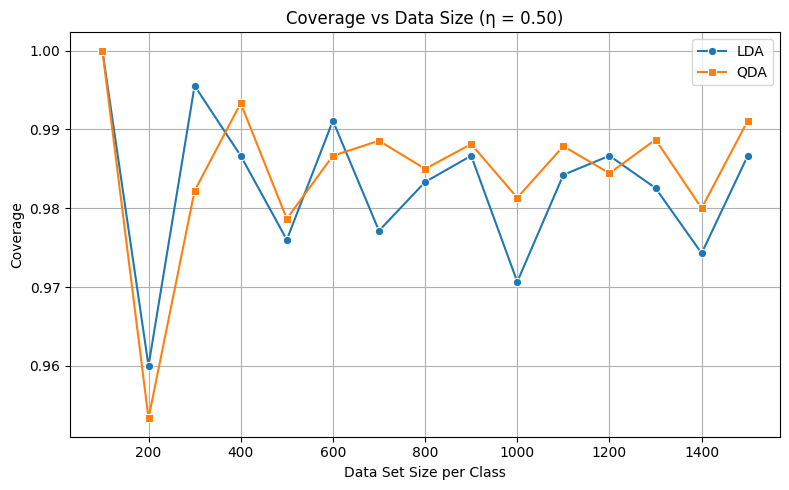

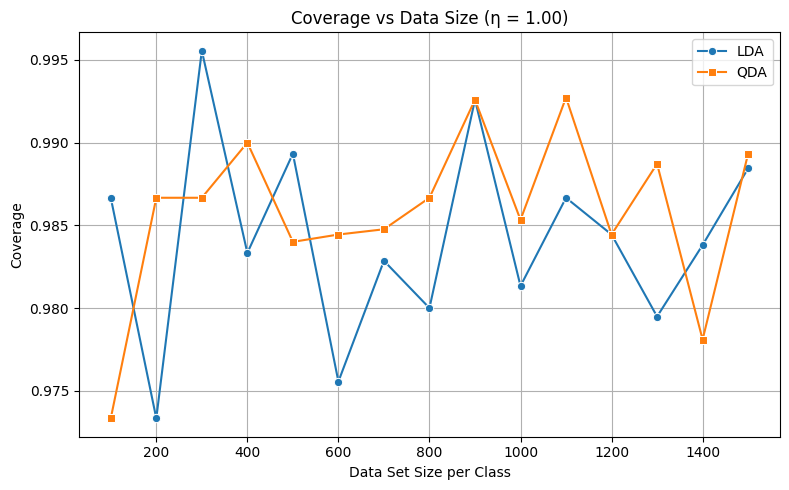

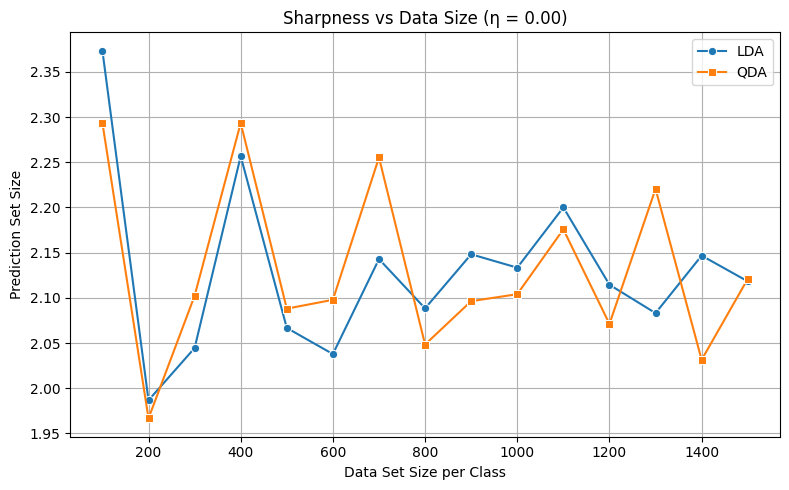

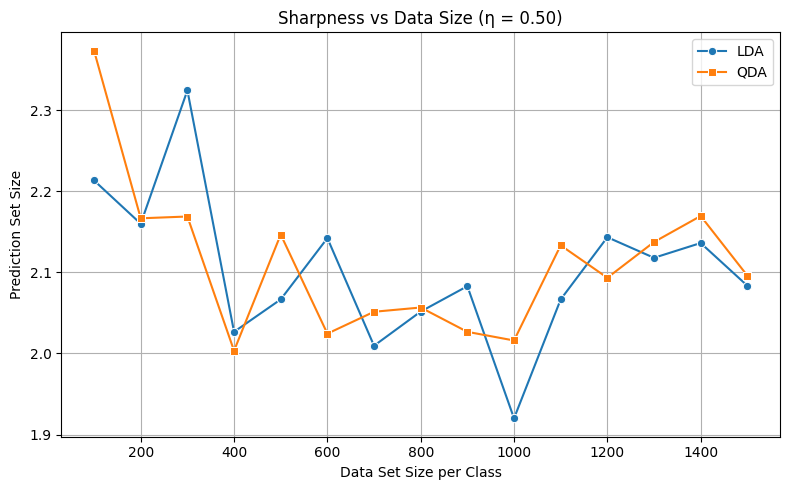

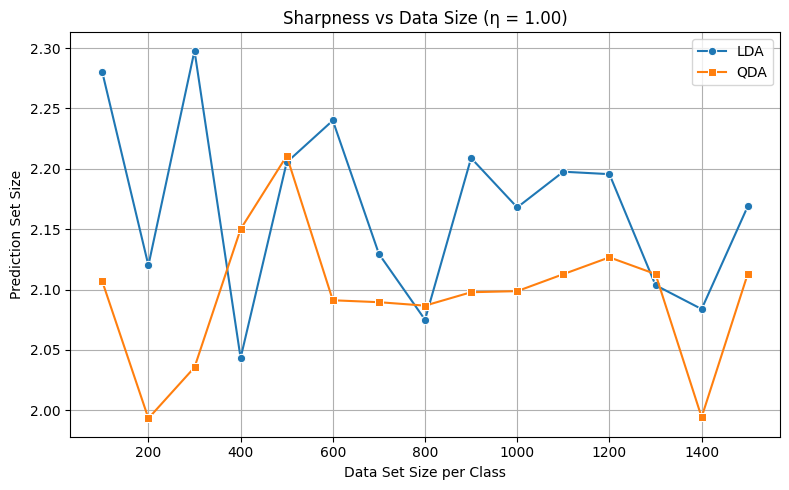

In [149]:
plot_metric_by_eta(results_df_size, metric="Coverage", title_prefix="Coverage vs Data Size", ylabel="Coverage")
plot_metric_by_eta(results_df_size, metric="Sharpness", title_prefix="Sharpness vs Data Size", ylabel="Prediction Set Size")


In [150]:
"""# Optional: set a save directory
save_folder = "plots_eta_metric"

plot_metric_by_eta(results_df_size, metric="Accuracy", title_prefix="Accuracy vs Data Size", ylabel="Accuracy", save_dir="plots_eta_metric")
plot_metric_by_eta(results_df_size, metric="Coverage", title_prefix="Coverage vs Data Size", ylabel="Coverage", save_dir="plots_eta_metric")
plot_metric_by_eta(results_df_size, metric="Sharpness", title_prefix="Sharpness vs Data Size", ylabel="Prediction Set Size", save_dir="plots_eta_metric")
"""

'# Optional: set a save directory\nsave_folder = "plots_eta_metric"\n\nplot_metric_by_eta(results_df_size, metric="Accuracy", title_prefix="Accuracy vs Data Size", ylabel="Accuracy", save_dir="plots_eta_metric")\nplot_metric_by_eta(results_df_size, metric="Coverage", title_prefix="Coverage vs Data Size", ylabel="Coverage", save_dir="plots_eta_metric")\nplot_metric_by_eta(results_df_size, metric="Sharpness", title_prefix="Sharpness vs Data Size", ylabel="Prediction Set Size", save_dir="plots_eta_metric")\n'

In [151]:
def run_scores_by_size(eta_values, total_sizes, means, shared_cov, class_covs, alpha=0.05, K=3, train_ratio=0.7, cal_ratio=0.1, test_ratio=0.2):
    results = []

    for eta in eta_values:
        for total_per_class in total_sizes:
            n_train = int(total_per_class * train_ratio)
            n_cal = int(total_per_class * cal_ratio)

            X_full, y_full = generate_data(
                n_per_class=total_per_class,
                eta=eta,
                K=K,
                means=means,
                shared_cov=shared_cov,
                class_covs=class_covs
            )
            y_full = y_full.astype(int)

            X_train, y_train, X_cal, y_cal, X_test, y_test = [], [], [], [], [], []

            for k in range(K):
                start = k * total_per_class
                end = (k + 1) * total_per_class
                X_k = X_full[start:end]
                y_k = y_full[start:end]

                X_train.append(X_k[:n_train])
                y_train.append(y_k[:n_train])
                X_cal.append(X_k[n_train:n_train + n_cal])
                y_cal.append(y_k[n_train:n_train + n_cal])
                X_test.append(X_k[n_train + n_cal:])
                y_test.append(y_k[n_train + n_cal:])

            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train)
            X_cal = np.vstack(X_cal)
            y_cal = np.concatenate(y_cal)
            X_test = np.vstack(X_test)
            y_test = np.concatenate(y_test)

            # LDA
            lda_model, y_pred_lda, y_set_lda, _ = compute_lda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
            if y_set_lda.ndim == 3:
                y_set_lda = y_set_lda[:, :, 0]
            lda_probs = lda_model.predict_proba(X_test)

            # QDA
            qda_model, y_pred_qda, y_set_qda, _ = compute_qda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
            if y_set_qda.ndim == 3:
                y_set_qda = y_set_qda[:, :, 0]
            qda_probs = qda_model.predict_proba(X_test)

            results.append({
                "eta": eta,
                "TotalPerClass": total_per_class,

                "LogScore_LDA": log_score(lda_probs, y_test),
                "Brier_LDA": brier_score(lda_probs, y_test),
                "Spherical_LDA": spherical_score(lda_probs, y_test),

                "LogScore_QDA": log_score(qda_probs, y_test),
                "Brier_QDA": brier_score(qda_probs, y_test),
                "Spherical_QDA": spherical_score(qda_probs, y_test),
            })

    return pd.DataFrame(results)


In [152]:
results_by_size = run_scores_by_size(
    eta_values=[0.0, 0.25, 0.5, 0.75, 1.0],
    total_sizes=[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500],
    means=means_global,
    shared_cov=shared_cov_global,
    class_covs=class_covs_global,
    alpha=0.05
)


In [153]:
import matplotlib.pyplot as plt

def plot_scores_by_size(df, eta_val, model_prefix='LDA', ylim=(0, 1), save_path=None):
    """
    Plot Log Score, Brier Score, and Spherical Score against dataset size for a fixed η.

    Args:
        df (pd.DataFrame): DataFrame containing 'TotalPerClass', 'eta',
                           and columns: 'LogScore_{model}', 'Brier_{model}', 'Spherical_{model}'
        eta_val (float): The η value to filter on
        model_prefix (str): 'LDA' or 'QDA'
        ylim (tuple): y-axis limits
        save_path (str or None): path to save the plot as PNG, or None to only display
    """
    subset = df[df["eta"] == eta_val]
    x = subset["TotalPerClass"]

    plt.figure(figsize=(8, 5))
    plt.plot(x, subset[f"LogScore_{model_prefix}"], marker='o', label='Log Score')
    plt.plot(x, subset[f"Brier_{model_prefix}"], marker='s', label='Brier Score')
    plt.plot(x, subset[f"Spherical_{model_prefix}"], marker='^', label='Spherical Score')

    plt.title(f'{model_prefix} Scores vs Data Set Size (η = {eta_val})')
    plt.xlabel('Data Set Size per Class')
    plt.ylabel('Score')
    plt.ylim(*ylim)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to {save_path}")
    plt.show()


In [154]:
"""etas = [0.0, 0.25, 0.5,0.75,  1.0]
models = ['LDA', 'QDA']

import os
os.makedirs("plots_scores_by_size", exist_ok=True)

for eta_val in etas:
    for model in models:
        fname = f"plots_scores_by_size/{model}_eta{eta_val:.2f}.png"
        plot_scores_by_size(results_by_size, eta_val=eta_val, model_prefix=model, save_path=fname)"""

'etas = [0.0, 0.25, 0.5,0.75,  1.0]\nmodels = [\'LDA\', \'QDA\']\n\nimport os\nos.makedirs("plots_scores_by_size", exist_ok=True)\n\nfor eta_val in etas:\n    for model in models:\n        fname = f"plots_scores_by_size/{model}_eta{eta_val:.2f}.png"\n        plot_scores_by_size(results_by_size, eta_val=eta_val, model_prefix=model, save_path=fname)'

In [155]:
import pandas as pd

# Ensure pandas displays all rows and columns
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Disable line wrapping
pd.set_option('display.max_colwidth', None)  # Show full column content

# Display the full DataFrame
print(results_by_size)


     eta  TotalPerClass  LogScore_LDA  Brier_LDA  Spherical_LDA  LogScore_QDA  \
0   0.00            100      0.593851   0.335532       0.805320      0.622046   
1   0.00            200      0.556262   0.303178       0.827625      0.555037   
2   0.00            300      0.523902   0.309287       0.820469      0.522204   
3   0.00            400      0.523667   0.303223       0.825642      0.531744   
4   0.00            500      0.484208   0.290231       0.833304      0.485042   
5   0.00            600      0.602767   0.353678       0.794279      0.602924   
6   0.00            700      0.572272   0.343689       0.800287      0.574653   
7   0.00            800      0.506985   0.300442       0.828133      0.506687   
8   0.00            900      0.532266   0.313001       0.819552      0.530695   
9   0.00           1000      0.540453   0.311675       0.822351      0.539776   
10  0.00           1100      0.499963   0.288237       0.836204      0.499499   
11  0.00           1200     

## Data Size average

In [156]:
def run_scoring_rule_experiment_average(
    eta_values,
    total_sizes,
    means,
    shared_cov,
    class_covs,
    alpha,
    K,
    train_ratio=0.5,
    cal_ratio=0.25,
    test_ratio=0.25,
    num_repeats=100,
    base_seed=1
):
    results = []

    for eta in eta_values:
        for total_per_class in total_sizes:
            n_train = int(total_per_class * train_ratio)
            n_cal = int(total_per_class * cal_ratio)

            log_lda, brier_lda, sph_lda = [], [], []
            log_qda, brier_qda, sph_qda = [], [], []

            for rep in range(num_repeats):
                current_seed = base_seed + rep
                np.random.seed(current_seed)

                X_full, y_full = generate_data(
                    n_per_class=total_per_class,
                    eta=eta,
                    K=K,
                    means=means,
                    shared_cov=shared_cov,
                    class_covs=class_covs
                )
            
                X_full, y_full = shuffle(X_full, y_full, random_state=current_seed)
                y_full = y_full.astype(int)


                X_train, y_train, X_cal, y_cal, X_test, y_test = [], [], [], [], [], []

                for k in range(K):
                    start = k * total_per_class
                    end = (k + 1) * total_per_class
                    X_k = X_full[start:end]
                    y_k = y_full[start:end]

                    X_train.append(X_k[:n_train])
                    y_train.append(y_k[:n_train])
                    X_cal.append(X_k[n_train:n_train + n_cal])
                    y_cal.append(y_k[n_train:n_train + n_cal])
                    X_test.append(X_k[n_train + n_cal:])
                    y_test.append(y_k[n_train + n_cal:])

                X_train = np.vstack(X_train)
                y_train = np.concatenate(y_train)
                X_cal = np.vstack(X_cal)
                y_cal = np.concatenate(y_cal)
                X_test = np.vstack(X_test)
                y_test = np.concatenate(y_test)

                # Skip invalid runs
                if len(np.unique(y_train)) < K or len(np.unique(y_cal)) < 2:
                    continue

                # LDA
                lda_model, _, _, _ = compute_lda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
                lda_probs = lda_model.predict_proba(X_test)
                log_lda.append(log_score(lda_probs, y_test))
                brier_lda.append(brier_score(lda_probs, y_test))
                sph_lda.append(spherical_score(lda_probs, y_test))

                # QDA
                qda_model, _, _, _ = compute_qda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
                qda_probs = qda_model.predict_proba(X_test)
                log_qda.append(log_score(qda_probs, y_test))
                brier_qda.append(brier_score(qda_probs, y_test))
                sph_qda.append(spherical_score(qda_probs, y_test))

            # Save averages
            if log_lda and log_qda:  # ensure at least one valid run
                results.append({
                    "eta": eta,
                    "TotalPerClass": total_per_class,
                    "LogScore_LDA": np.mean(log_lda),
                    "Brier_LDA": np.mean(brier_lda),
                    "Spherical_LDA": np.mean(sph_lda),
                    "LogScore_QDA": np.mean(log_qda),
                    "Brier_QDA": np.mean(brier_qda),
                    "Spherical_QDA": np.mean(sph_qda),
                    "ValidRuns": len(log_lda)
                })

    return pd.DataFrame(results)


In [157]:
print(y_cal)

[1 1 0 1 1 1 1 2 2 1 1 1 0 2 1 1 0 0 1 2 1 1 1 2 1 1 1 0 2 1 0 1 1 0 2 0 0
 0 1 1 0 2 1 0 1 0 2 0 0 1 0 1 2 1 0 1 1 1 1 1 0 0 0 0 2 1 2 2 2 0 1 1 2 1
 0 2 0 1 2 1 2 0 0 1 0 2 0 1 1 0 0 2 2 1 1 1 2 0 0 2 2 1 0 1 0 2 1 1 1 1 2
 1 0 2 2 2 2 2 2 0 0 0 1 0 1 0 0 2 0 1 2 1 0 1 1 1 1 2 0 2 1 1 2 0 2 0 0 1
 1 1 1 0 2 1 2 1 1 2 1 0 1 1 2 2 0 0 1 0 0 2 1 1 1 1 1 2 1 1 2 1 0 1 0 2 0
 0 1 2 2 0 2 1 2 0 1 2 1 0 2 0 0 1 1 0 1 2 2 0 0 1 2 2 1 2 0 2 0 2 2 2 1 1
 1 0 0 1 1 0 2 1 2 0 1 2 2 1 0 2 1 1 2 1 0 2 1 2 2 0 0 2 1 2 0 0 2 2 2 2 1
 0 0 0 0 1 1 2 1 2 2 2 1 0 0 2 1 2 0 2 2 1 2 1 2 1 2 1 1 1 0 0 2 0 0 1 0 1
 2 1 0 2]


In [158]:
results_by_size_average = run_scoring_rule_experiment_average(
    eta_values=eta_vals,
    total_sizes=total_sizes,
    means=means_global,
    K=k,
    shared_cov=shared_cov_global,
    class_covs=class_covs_global,
    alpha= desired_alpha,
    num_repeats=100
)

In [159]:
def plot_scores_comparison_by_eta(df, eta_val, save_path=None):
    """
    Plot Log, Brier, and Spherical Scores of LDA and QDA on the same figure for a given η,
    using automatically computed y-axis limits for each subplot.

    Args:
        df (pd.DataFrame): DataFrame containing score columns for both LDA and QDA
        eta_val (float): η value to filter on
        save_path (str or None): If set, saves the figure to this path
    """
    subset = df[df["eta"] == eta_val].sort_values("TotalPerClass")
    x = subset["TotalPerClass"]
    scores = ["LogScore", "Brier", "Spherical"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for i, score in enumerate(scores):
        ax = axes[i]
        lda_vals = subset[f"{score}_LDA"]
        qda_vals = subset[f"{score}_QDA"]

        ax.plot(x, lda_vals, marker='o', label='LDA')
        ax.plot(x, qda_vals, marker='s', label='QDA')

        ymin = min(lda_vals.min(), qda_vals.min()) - 0.05
        ymax = max(lda_vals.max(), qda_vals.max()) + 0.05
        ax.set_ylim(ymin, ymax)

        ax.set_title(f"{score} Score")
        ax.set_xlabel("Data Set Size per Class")
        if i == 0:
            ax.set_ylabel("Score")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Scoring Rule Comparison (η = {eta_val})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
    plt.show()


✅ Saved: plots_average_scores_comparison/normal_scores_eta0.00.png


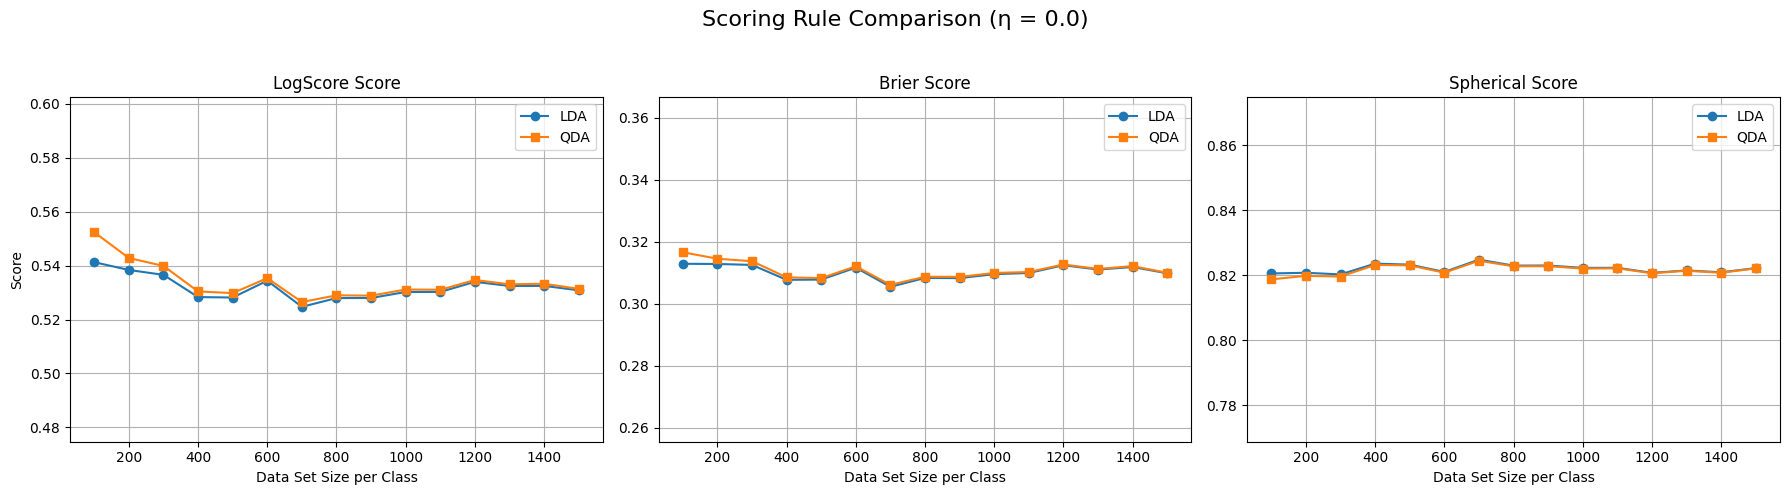

✅ Saved: plots_average_scores_comparison/normal_scores_eta0.50.png


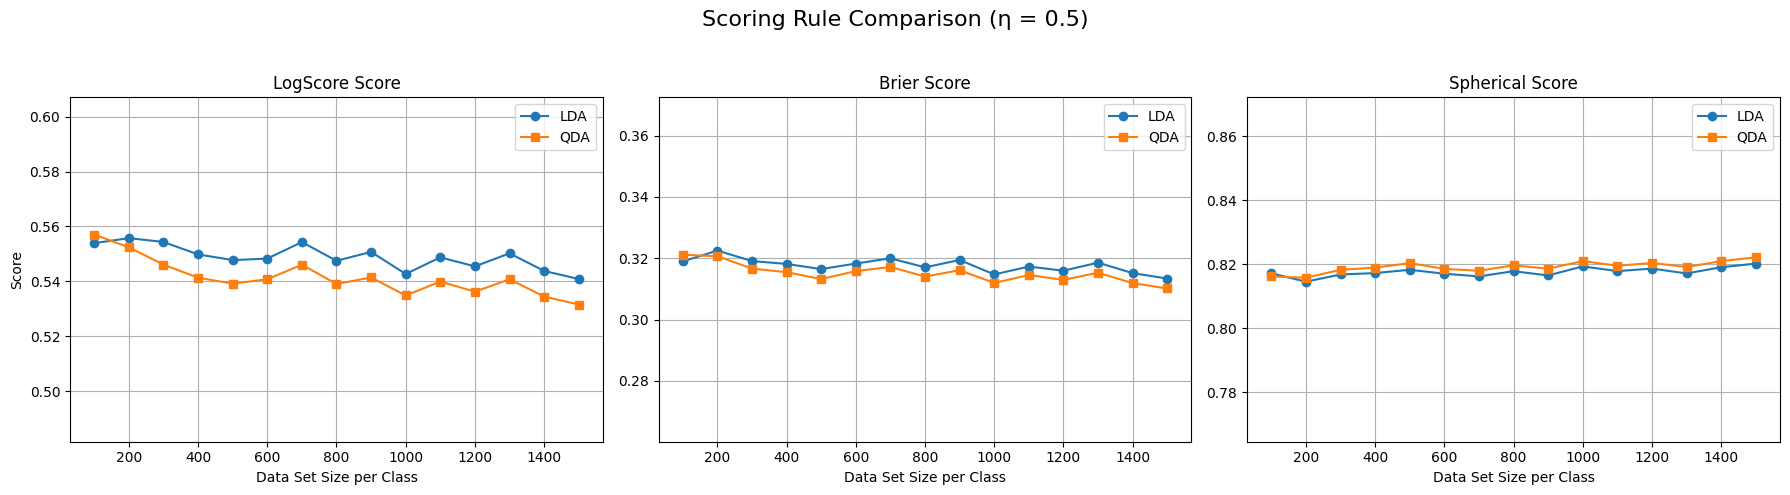

✅ Saved: plots_average_scores_comparison/normal_scores_eta1.00.png


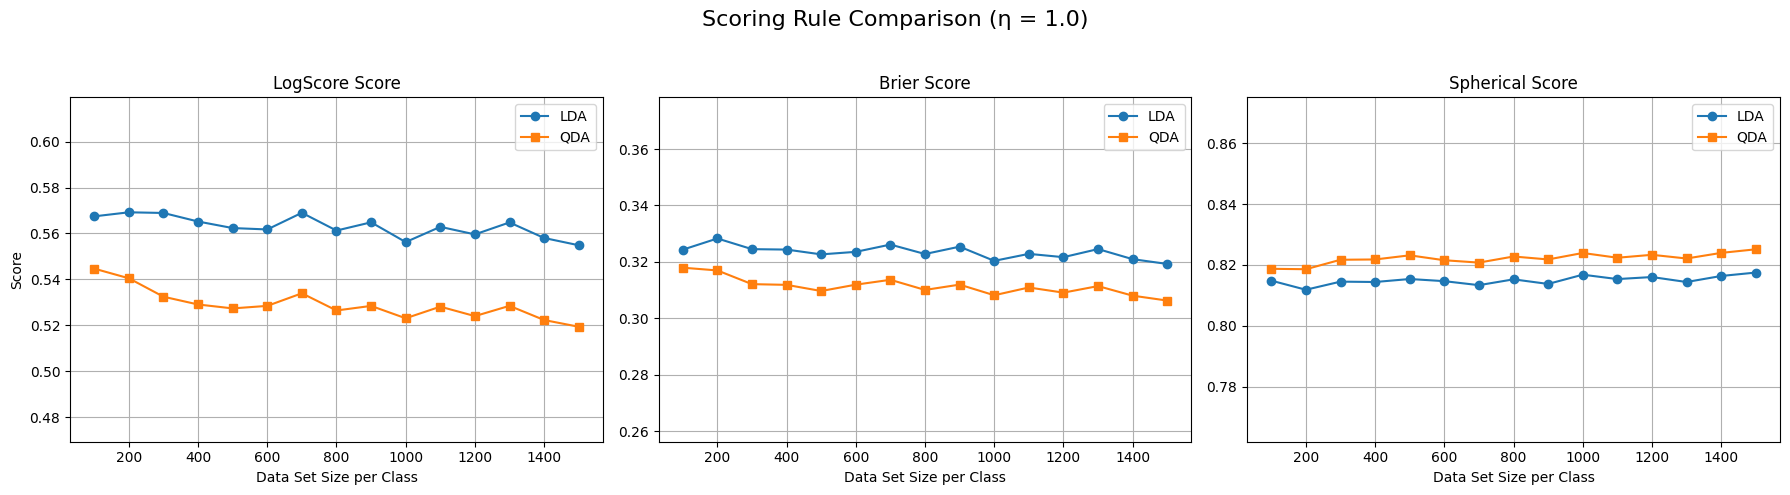

In [160]:
etas = [0.0, 0.5, 1.0]
os.makedirs("plots_average_scores_comparison", exist_ok=True)

for eta_val in etas:
    path = f"plots_average_scores_comparison/normal_scores_eta{eta_val:.2f}.png"
    plot_scores_comparison_by_eta(results_by_size_average, eta_val=eta_val, save_path=path)


In [161]:
def plot_coverage_and_sharpness(df, save_dir=None):
    """
    Plot Coverage and Sharpness of LDA and QDA for η = 0, 0.5, 1.
    Generates one figure per η.

    Args:
        df (pd.DataFrame): DataFrame containing Coverage and Sharpness columns for both LDA and QDA
        save_dir (str or None): If set, saves each figure to this folder
    """
    target_etas = [0.0, 0.5, 1.0]

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    for eta_val in target_etas:
        subset = df[df["eta"] == eta_val].sort_values("TotalPerClass")
        if subset.empty:
            continue  # Skip if no data

        x = subset["TotalPerClass"]
        metrics = ["Coverage", "Sharpness"]

        fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

        for i, metric in enumerate(metrics):
            ax = axes[i]
            lda_vals = subset[f"LDA_{metric}"]
            qda_vals = subset[f"QDA_{metric}"]

            ax.plot(x, lda_vals, marker='o', label='LDA')
            ax.plot(x, qda_vals, marker='s', label='QDA')

            ymin = min(lda_vals.min(), qda_vals.min()) - 0.05
            ymax = max(lda_vals.max(), qda_vals.max()) + 0.05
            ax.set_ylim(ymin, ymax)

            ax.set_title(metric)
            ax.set_xlabel("Data Set Size per Class")
            if i == 0:
                ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()

        plt.suptitle(f"Coverage and Sharpness Comparison (η = {eta_val})", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if save_dir:
            filename = f"coverage_sharpness_eta={eta_val:.2f}.png"
            path = os.path.join(save_dir, filename)
            plt.savefig(path, dpi=300)
            print(f"✅ Saved: {path}")

        plt.show()


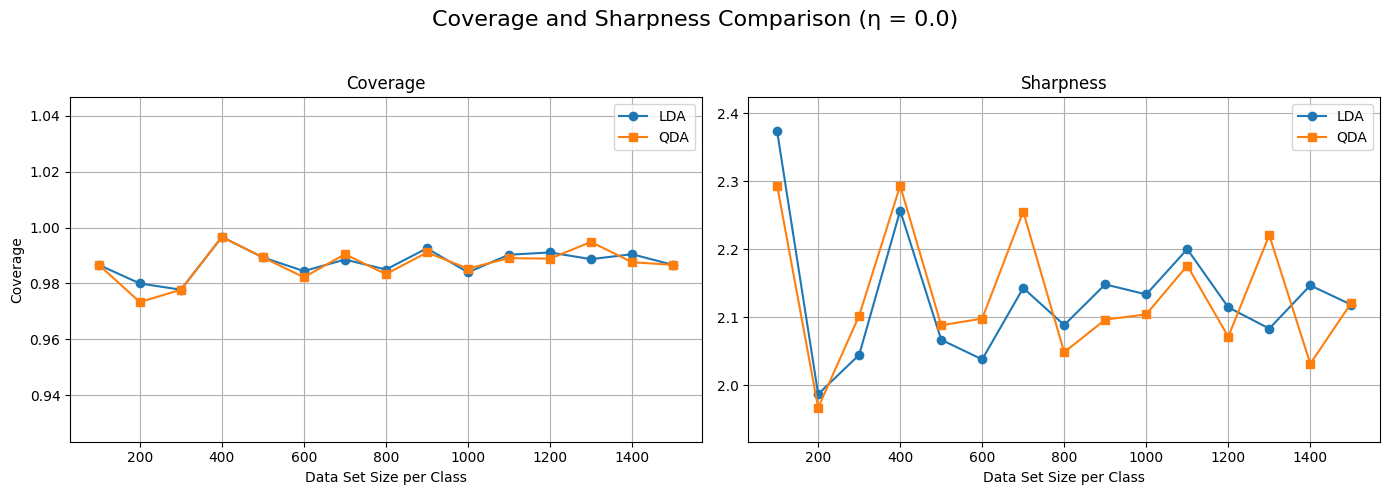

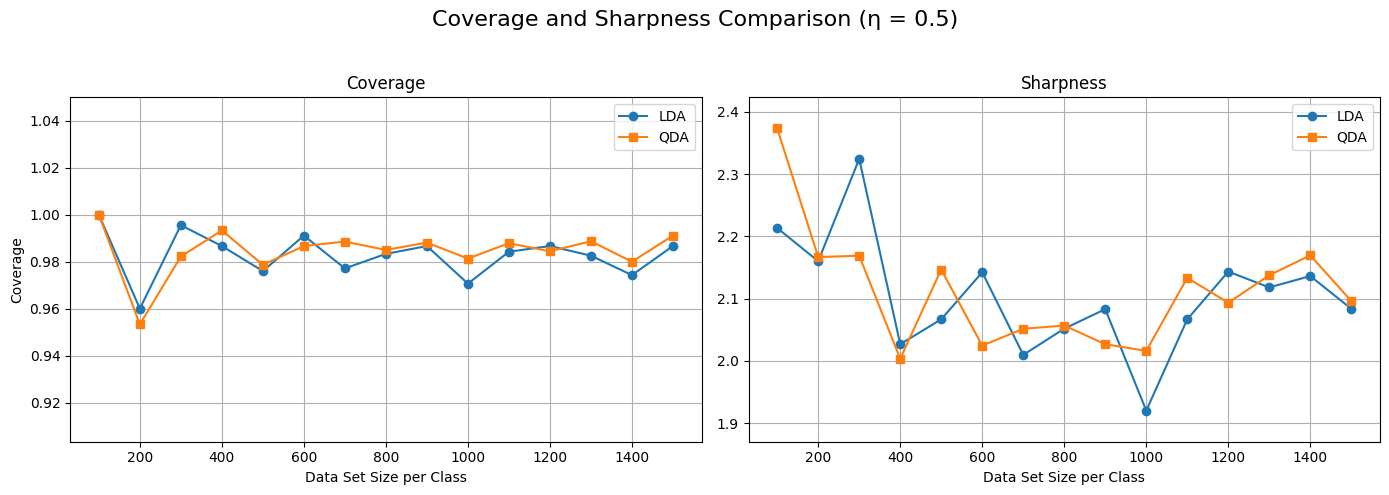

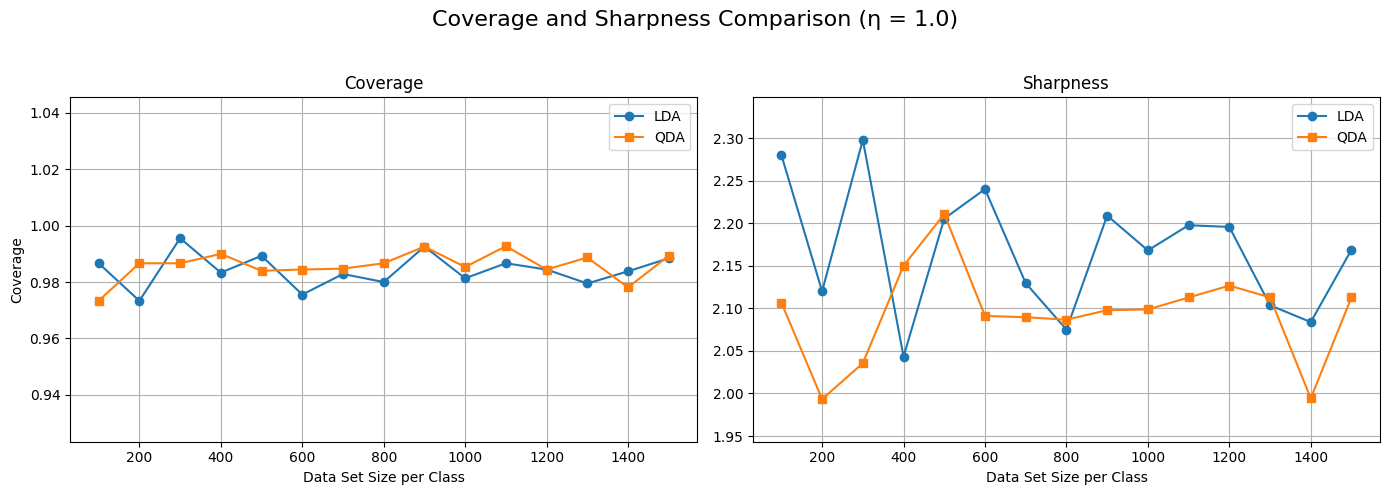

In [162]:
plot_coverage_and_sharpness(results_df_size)


## Calibration Set Size


In [163]:
def run_calibration_size_experiment(
    eta_values,
    cal_sizes,
    n_train_per_class=200,
    n_test_per_class=100,
    K=3,
    means=None,
    shared_cov=None,
    class_covs=None,
    alpha=0.1,
    random_seed=42
):
    results = []
    np.random.seed(random_seed)

    for eta_val in eta_values:
        for n_cal_per_class in cal_sizes:
            total_per_class = n_train_per_class + n_cal_per_class + n_test_per_class

            print(f"\n--- η = {eta_val:.2f} | Cal Size = {n_cal_per_class} ---")

            X_full, y_full = generate_data(
                n_per_class=total_per_class,
                eta=eta_val,
                K=K,
                means=means,
                shared_cov=shared_cov,
                class_covs=class_covs
            )
            y_full = y_full.astype(int)

            # Split per class
            X_train, y_train, X_cal, y_cal, X_test, y_test = [], [], [], [], [], []

            for k in range(K):
                start = k * total_per_class
                end = (k + 1) * total_per_class
                X_k = X_full[start:end]
                y_k = y_full[start:end]

                X_train.append(X_k[:n_train_per_class])
                y_train.append(y_k[:n_train_per_class])
                X_cal.append(X_k[n_train_per_class:n_train_per_class + n_cal_per_class])
                y_cal.append(y_k[n_train_per_class:n_train_per_class + n_cal_per_class])
                X_test.append(X_k[n_train_per_class + n_cal_per_class:])
                y_test.append(y_k[n_train_per_class + n_cal_per_class:])

            X_train = np.vstack(X_train)
            y_train = np.concatenate(y_train)
            X_cal = np.vstack(X_cal)
            y_cal = np.concatenate(y_cal)
            X_test = np.vstack(X_test)
            y_test = np.concatenate(y_test)

            if len(np.unique(y_cal)) < 2:
                print(f"  Skipped: Only one class in calibration for η = {eta_val}")
                continue

            # LDA
            lda_model, y_pred_lda, y_set_lda, _ = compute_lda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
            if y_set_lda.ndim == 3:
                y_set_lda = y_set_lda[:, :, 0]
            lda_probs = lda_model.predict_proba(X_test)

            # QDA
            qda_model, y_pred_qda, y_set_qda, _ = compute_qda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
            if y_set_qda.ndim == 3:
                y_set_qda = y_set_qda[:, :, 0]
            qda_probs = qda_model.predict_proba(X_test)

            results.append({
                "eta": eta_val,
                "CalSize": n_cal_per_class,
                "LDA_Accuracy": np.mean(y_pred_lda == y_test),
                "LDA_Coverage": classification_coverage_score(y_test, y_set_lda),
                "LDA_Sharpness": classification_mean_width_score(y_set_lda),
                "LogScore_LDA": log_score(lda_probs, y_test),
                "Brier_LDA": brier_score(lda_probs, y_test),
                "Spherical_LDA": spherical_score(lda_probs, y_test),
                "QDA_Accuracy": np.mean(y_pred_qda == y_test),
                "QDA_Coverage": classification_coverage_score(y_test, y_set_qda),
                "QDA_Sharpness": classification_mean_width_score(y_set_qda),
                "LogScore_QDA": log_score(qda_probs, y_test),
                "Brier_QDA": brier_score(qda_probs, y_test),
                "Spherical_QDA": spherical_score(qda_probs, y_test)
            })

    return pd.DataFrame(results)


In [164]:
print(k)

3


In [165]:
# Fixed train/test sizes, vary calibration size
cal_sizes = list(range(10, 1010, 20))
eta_vals = [0.0, 0.5, 1.0]

results_cal_size = run_calibration_size_experiment(
    eta_values=eta_vals,
    cal_sizes=cal_sizes,
    n_train_per_class=n_train_per_c,
    n_test_per_class=n_test_per_c,
    K=k,
    means=means_global,
    shared_cov=shared_cov_global,
    class_covs=class_covs_global,
    alpha=desired_alpha
)



--- η = 0.00 | Cal Size = 10 ---

--- η = 0.00 | Cal Size = 30 ---

--- η = 0.00 | Cal Size = 50 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 70 ---

--- η = 0.00 | Cal Size = 90 ---

--- η = 0.00 | Cal Size = 110 ---

--- η = 0.00 | Cal Size = 130 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 150 ---

--- η = 0.00 | Cal Size = 170 ---

--- η = 0.00 | Cal Size = 190 ---

--- η = 0.00 | Cal Size = 210 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 230 ---

--- η = 0.00 | Cal Size = 250 ---

--- η = 0.00 | Cal Size = 270 ---

--- η = 0.00 | Cal Size = 290 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 310 ---

--- η = 0.00 | Cal Size = 330 ---

--- η = 0.00 | Cal Size = 350 ---

--- η = 0.00 | Cal Size = 370 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 390 ---

--- η = 0.00 | Cal Size = 410 ---

--- η = 0.00 | Cal Size = 430 ---

--- η = 0.00 | Cal Size = 450 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 470 ---

--- η = 0.00 | Cal Size = 490 ---

--- η = 0.00 | Cal Size = 510 ---

--- η = 0.00 | Cal Size = 530 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 550 ---

--- η = 0.00 | Cal Size = 570 ---

--- η = 0.00 | Cal Size = 590 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 610 ---

--- η = 0.00 | Cal Size = 630 ---

--- η = 0.00 | Cal Size = 650 ---

--- η = 0.00 | Cal Size = 670 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 690 ---

--- η = 0.00 | Cal Size = 710 ---

--- η = 0.00 | Cal Size = 730 ---

--- η = 0.00 | Cal Size = 750 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 770 ---

--- η = 0.00 | Cal Size = 790 ---

--- η = 0.00 | Cal Size = 810 ---

--- η = 0.00 | Cal Size = 830 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 850 ---

--- η = 0.00 | Cal Size = 870 ---

--- η = 0.00 | Cal Size = 890 ---

--- η = 0.00 | Cal Size = 910 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.00 | Cal Size = 930 ---

--- η = 0.00 | Cal Size = 950 ---

--- η = 0.00 | Cal Size = 970 ---

--- η = 0.00 | Cal Size = 990 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 10 ---

--- η = 0.50 | Cal Size = 30 ---

--- η = 0.50 | Cal Size = 50 ---

--- η = 0.50 | Cal Size = 70 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 90 ---

--- η = 0.50 | Cal Size = 110 ---

--- η = 0.50 | Cal Size = 130 ---

--- η = 0.50 | Cal Size = 150 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 170 ---

--- η = 0.50 | Cal Size = 190 ---

--- η = 0.50 | Cal Size = 210 ---

--- η = 0.50 | Cal Size = 230 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 250 ---

--- η = 0.50 | Cal Size = 270 ---

--- η = 0.50 | Cal Size = 290 ---

--- η = 0.50 | Cal Size = 310 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 330 ---

--- η = 0.50 | Cal Size = 350 ---

--- η = 0.50 | Cal Size = 370 ---

--- η = 0.50 | Cal Size = 390 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 410 ---

--- η = 0.50 | Cal Size = 430 ---

--- η = 0.50 | Cal Size = 450 ---

--- η = 0.50 | Cal Size = 470 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 490 ---

--- η = 0.50 | Cal Size = 510 ---

--- η = 0.50 | Cal Size = 530 ---

--- η = 0.50 | Cal Size = 550 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 570 ---

--- η = 0.50 | Cal Size = 590 ---

--- η = 0.50 | Cal Size = 610 ---

--- η = 0.50 | Cal Size = 630 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 650 ---

--- η = 0.50 | Cal Size = 670 ---

--- η = 0.50 | Cal Size = 690 ---

--- η = 0.50 | Cal Size = 710 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 730 ---

--- η = 0.50 | Cal Size = 750 ---

--- η = 0.50 | Cal Size = 770 ---

--- η = 0.50 | Cal Size = 790 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 810 ---

--- η = 0.50 | Cal Size = 830 ---

--- η = 0.50 | Cal Size = 850 ---

--- η = 0.50 | Cal Size = 870 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 890 ---

--- η = 0.50 | Cal Size = 910 ---

--- η = 0.50 | Cal Size = 930 ---

--- η = 0.50 | Cal Size = 950 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 0.50 | Cal Size = 970 ---

--- η = 0.50 | Cal Size = 990 ---

--- η = 1.00 | Cal Size = 10 ---

--- η = 1.00 | Cal Size = 30 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 50 ---

--- η = 1.00 | Cal Size = 70 ---

--- η = 1.00 | Cal Size = 90 ---

--- η = 1.00 | Cal Size = 110 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 130 ---

--- η = 1.00 | Cal Size = 150 ---

--- η = 1.00 | Cal Size = 170 ---

--- η = 1.00 | Cal Size = 190 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 210 ---

--- η = 1.00 | Cal Size = 230 ---

--- η = 1.00 | Cal Size = 250 ---

--- η = 1.00 | Cal Size = 270 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 290 ---

--- η = 1.00 | Cal Size = 310 ---

--- η = 1.00 | Cal Size = 330 ---

--- η = 1.00 | Cal Size = 350 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 370 ---

--- η = 1.00 | Cal Size = 390 ---

--- η = 1.00 | Cal Size = 410 ---

--- η = 1.00 | Cal Size = 430 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 450 ---

--- η = 1.00 | Cal Size = 470 ---

--- η = 1.00 | Cal Size = 490 ---

--- η = 1.00 | Cal Size = 510 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 530 ---

--- η = 1.00 | Cal Size = 550 ---

--- η = 1.00 | Cal Size = 570 ---

--- η = 1.00 | Cal Size = 590 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 610 ---

--- η = 1.00 | Cal Size = 630 ---

--- η = 1.00 | Cal Size = 650 ---

--- η = 1.00 | Cal Size = 670 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 690 ---

--- η = 1.00 | Cal Size = 710 ---

--- η = 1.00 | Cal Size = 730 ---

--- η = 1.00 | Cal Size = 750 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 770 ---

--- η = 1.00 | Cal Size = 790 ---

--- η = 1.00 | Cal Size = 810 ---

--- η = 1.00 | Cal Size = 830 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 850 ---

--- η = 1.00 | Cal Size = 870 ---

--- η = 1.00 | Cal Size = 890 ---

--- η = 1.00 | Cal Size = 910 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/


--- η = 1.00 | Cal Size = 930 ---

--- η = 1.00 | Cal Size = 950 ---

--- η = 1.00 | Cal Size = 970 ---

--- η = 1.00 | Cal Size = 990 ---


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [166]:
def plot_metric_by_calibration(df, metric="Accuracy", ylabel=""):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))

    # Plot LDA
    sns.lineplot(
        data=df,
        x="CalSize",
        y=f"LDA_{metric}",
        hue="eta",
        marker="o",
        linestyle="-",
        palette="tab10"
    )

    # Plot QDA
    sns.lineplot(
        data=df,
        x="CalSize",
        y=f"QDA_{metric}",
        hue="eta",
        marker="s",
        linestyle="--",
        palette="tab10"
    )

    plt.title(f"{metric} vs Calibration Set Size")
    plt.xlabel("Calibration Set Size per Class")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(title="η")
    plt.tight_layout()
    plt.show()


In [167]:
"""plot_metric_by_calibration(
    df=results_cal_size,
    metric="Sharpness",
    ylabel="Mean Prediction Set Size"
)

plot_metric_by_calibration(
    df=results_cal_size,
    metric="Coverage",
    ylabel="Coverage Rate"
)

plot_metric_by_calibration(
    df=results_cal_size,
    metric="Accuracy",
    ylabel="Classification Accuracy"
)
"""

'plot_metric_by_calibration(\n    df=results_cal_size,\n    metric="Sharpness",\n    ylabel="Mean Prediction Set Size"\n)\n\nplot_metric_by_calibration(\n    df=results_cal_size,\n    metric="Coverage",\n    ylabel="Coverage Rate"\n)\n\nplot_metric_by_calibration(\n    df=results_cal_size,\n    metric="Accuracy",\n    ylabel="Classification Accuracy"\n)\n'

## Calibration Set Average

In [168]:
def run_calibration_size_experiment_average_with_std(
    eta_values,
    cal_sizes,
    n_train_per_class=200,
    n_test_per_class=100,
    K=3,
    means=None,
    shared_cov=None,
    class_covs=None,
    alpha=0.1,
    num_repeats=100,
    base_seed=1
):
    all_records = []

    for eta_val in eta_values:
        for n_cal_per_class in cal_sizes:
            total_per_class = n_train_per_class + n_cal_per_class + n_test_per_class

            for rep in range(num_repeats):
                seed = base_seed + rep
                np.random.seed(seed)

                X_full, y_full = generate_data(
                    n_per_class=total_per_class,
                    eta=eta_val,
                    K=K,
                    means=means,
                    shared_cov=shared_cov,
                    class_covs=class_covs
                )
                y_full = y_full.astype(int)

                X_train, y_train, X_cal, y_cal, X_test, y_test = [], [], [], [], [], []

                for k in range(K):
                    start = k * total_per_class
                    end = (k + 1) * total_per_class
                    X_k = X_full[start:end]
                    y_k = y_full[start:end]

                    X_train.append(X_k[:n_train_per_class])
                    y_train.append(y_k[:n_train_per_class])
                    X_cal.append(X_k[n_train_per_class:n_train_per_class + n_cal_per_class])
                    y_cal.append(y_k[n_train_per_class:n_train_per_class + n_cal_per_class])
                    X_test.append(X_k[n_train_per_class + n_cal_per_class:])
                    y_test.append(y_k[n_train_per_class + n_cal_per_class:])

                X_train = np.vstack(X_train)
                y_train = np.concatenate(y_train)
                X_cal = np.vstack(X_cal)
                y_cal = np.concatenate(y_cal)
                X_test = np.vstack(X_test)
                y_test = np.concatenate(y_test)

                if len(np.unique(y_cal)) < 2:
                    continue

                lda_model, y_pred_lda, y_set_lda, _ = compute_lda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
                if y_set_lda.ndim == 3:
                    y_set_lda = y_set_lda[:, :, 0]
                lda_probs = lda_model.predict_proba(X_test)

                qda_model, y_pred_qda, y_set_qda, _ = compute_qda_conformal(X_train, y_train, X_cal, y_cal, X_test, alpha)
                if y_set_qda.ndim == 3:
                    y_set_qda = y_set_qda[:, :, 0]
                qda_probs = qda_model.predict_proba(X_test)

                all_records.append({
                    "eta": eta_val,
                    "CalSize": n_cal_per_class,
                    "LDA_Accuracy": np.mean(y_pred_lda == y_test),
                    "LDA_Coverage": classification_coverage_score(y_test, y_set_lda),
                    "LDA_Sharpness": classification_mean_width_score(y_set_lda),
                    "LogScore_LDA": log_score(lda_probs, y_test),
                    "Brier_LDA": brier_score(lda_probs, y_test),
                    "Spherical_LDA": spherical_score(lda_probs, y_test),
                    "QDA_Accuracy": np.mean(y_pred_qda == y_test),
                    "QDA_Coverage": classification_coverage_score(y_test, y_set_qda),
                    "QDA_Sharpness": classification_mean_width_score(y_set_qda),
                    "LogScore_QDA": log_score(qda_probs, y_test),
                    "Brier_QDA": brier_score(qda_probs, y_test),
                    "Spherical_QDA": spherical_score(qda_probs, y_test),
                })

    full_df = pd.DataFrame(all_records)
    mean_df = full_df.groupby(["eta", "CalSize"]).mean(numeric_only=True).reset_index()
    std_df = full_df.groupby(["eta", "CalSize"]).std(numeric_only=True).reset_index()

    return mean_df, std_df, full_df


In [169]:
cal_sizes = list(range(10, 310, 20))
eta_vals = [0.0, 0.5, 1.0]

mean_df, std_df, full_df = run_calibration_size_experiment_average_with_std(
    eta_values=eta_vals,
    cal_sizes=cal_sizes,
    n_train_per_class=n_train_per_c,
    n_test_per_class=n_test_per_c,
    K=k,
    means=means_global,
    shared_cov=shared_cov_global,
    class_covs=class_covs_global,
    alpha=desired_alpha,
    num_repeats=100
)


/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elenalickel/Desktop/Thesis/IRR_Code/IRR_venv/lib/

In [170]:
def plot_metric_by_calibration_average(df, metric="Accuracy", ylabel="", save_path=None):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("tab10", n_colors=df["eta"].nunique())
    eta_vals = sorted(df["eta"].unique())

    for i, eta_val in enumerate(eta_vals):
        sub_df = df[df["eta"] == eta_val].sort_values("CalSize")

        # Plot LDA
        plt.plot(
            sub_df["CalSize"],
            sub_df[f"LDA_{metric}"],
            marker="o",
            linestyle="-",
            label=f"LDA (η = {eta_val})",
            color=palette[i]
        )

        # Plot QDA
        plt.plot(
            sub_df["CalSize"],
            sub_df[f"QDA_{metric}"],
            marker="s",
            linestyle="--",
            label=f"QDA (η = {eta_val})",
            color=palette[i]
        )

    plt.title(f"{metric} vs Calibration Set Size", fontsize=14)
    plt.xlabel("Calibration Set Size per Class")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(title="Model (η)", fontsize=10)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
    plt.show()


In [171]:
"""plot_metric_by_calibration_average(
    df=mean_df,
    metric="Sharpness",
    ylabel="Mean Prediction Set Size"
)

plot_metric_by_calibration_average(
    df=mean_df,
    metric="Coverage",
    ylabel="Coverage Rate"
)

plot_metric_by_calibration_average(
    df=mean_df,
    metric="Accuracy",
    ylabel="Classification Accuracy"
)
"""

'plot_metric_by_calibration_average(\n    df=mean_df,\n    metric="Sharpness",\n    ylabel="Mean Prediction Set Size"\n)\n\nplot_metric_by_calibration_average(\n    df=mean_df,\n    metric="Coverage",\n    ylabel="Coverage Rate"\n)\n\nplot_metric_by_calibration_average(\n    df=mean_df,\n    metric="Accuracy",\n    ylabel="Classification Accuracy"\n)\n'

✅ Saved: plots_scores_by_cal_size/normal_scores_eta0.00.png


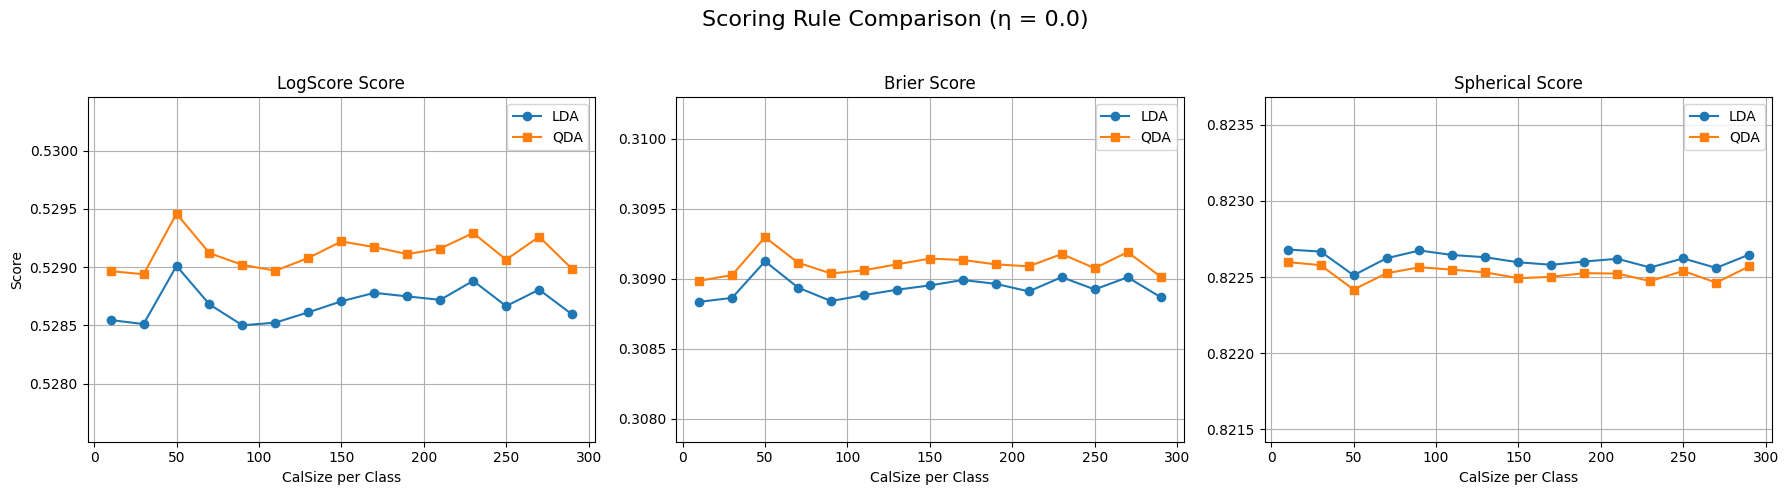

✅ Saved: plots_scores_by_cal_size/normal_scores_eta0.50.png


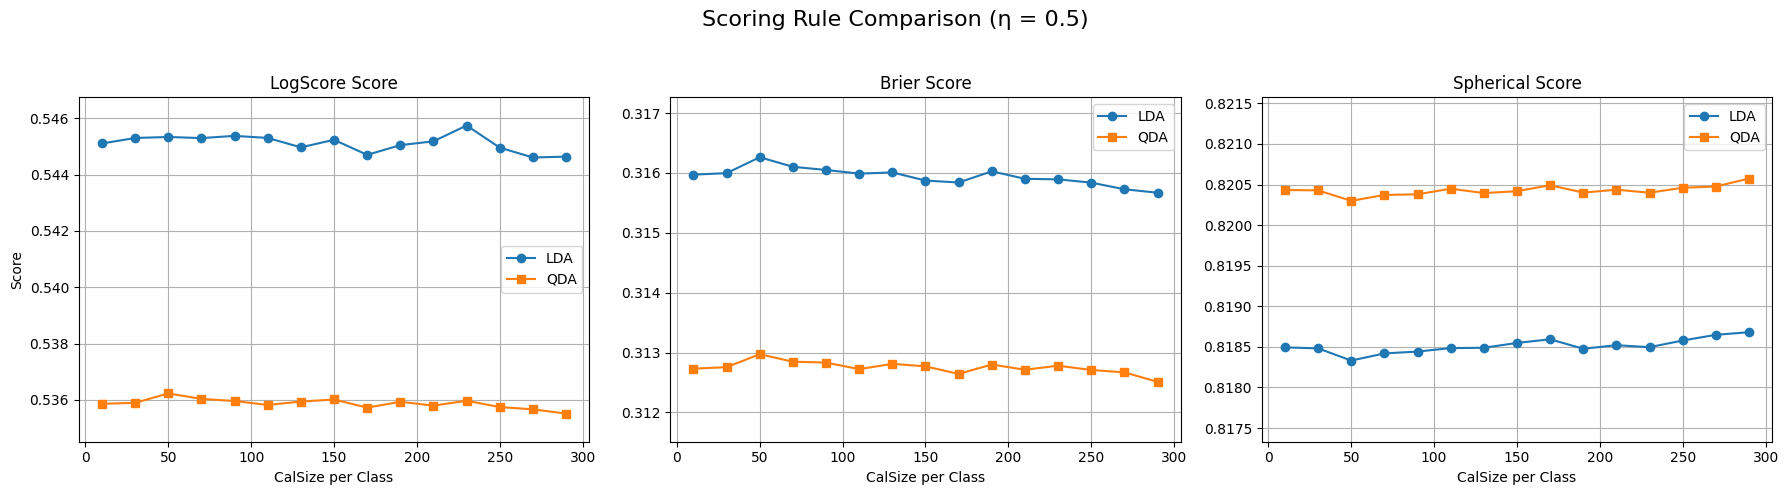

✅ Saved: plots_scores_by_cal_size/normal_scores_eta1.00.png


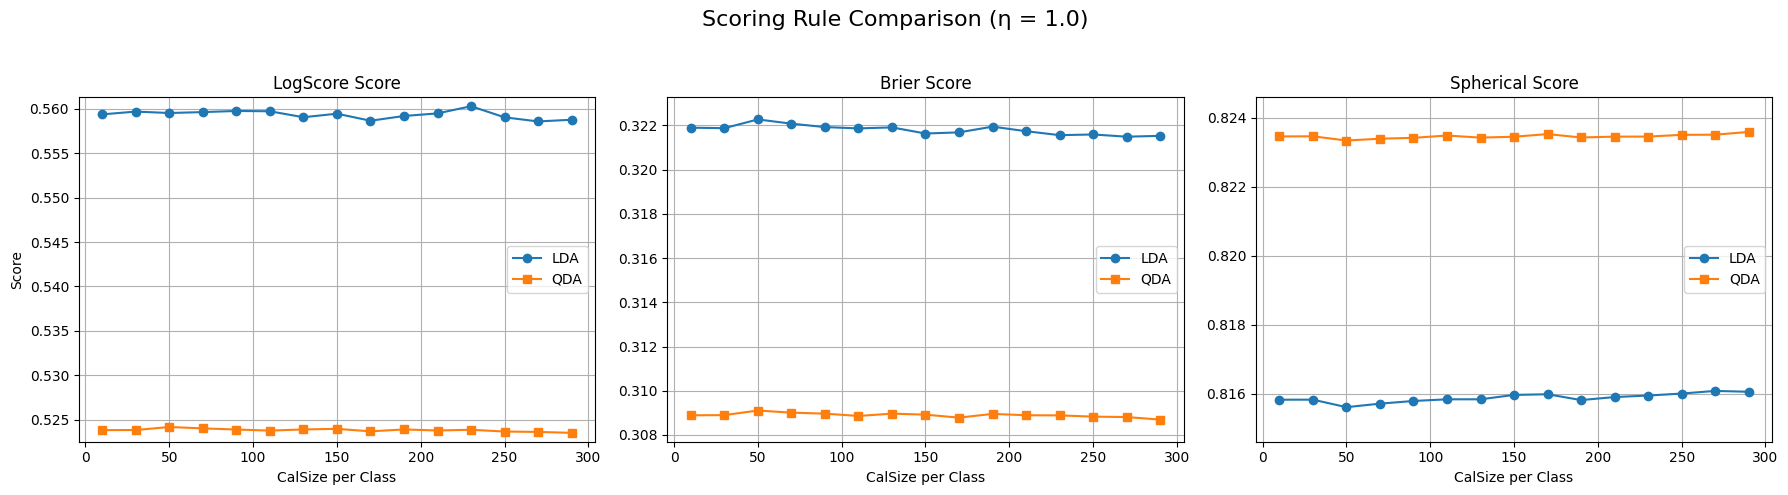

In [172]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure the folder exists
os.makedirs("plots_scores_by_cal_size", exist_ok=True)

# Use eta_vals and mean_df from results
eta_vals = [0.0, 0.5, 1.0]

def plot_scores_comparison_by_eta(df, eta_val, ylim=None, save_path=None):
    """
    Plot Log, Brier, and Spherical Scores of LDA and QDA for a given η as 3 subplots.
    Automatically detects x-axis column (TotalPerClass or CalSize).
    """
    x_col = "TotalPerClass" if "TotalPerClass" in df.columns else "CalSize"
    
    # Use np.isclose for float matching
    subset = df[np.isclose(df["eta"], eta_val)].sort_values(x_col)
    x = subset[x_col]
    scores = ["LogScore", "Brier", "Spherical"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    for i, score in enumerate(scores):
        ax = axes[i]
        y_lda = subset[f"{score}_LDA"]
        y_qda = subset[f"{score}_QDA"]
        ax.plot(x, y_lda, marker='o', label='LDA')
        ax.plot(x, y_qda, marker='s', label='QDA')
        ax.set_title(f"{score} Score")

        if ylim:
            ax.set_ylim(*ylim)
        else:
            ymin = min(y_lda.min(), y_qda.min()) - 0.001
            ymax = max(y_lda.max(), y_qda.max()) + 0.001
            ax.set_ylim(ymin, ymax)

        ax.set_xlabel(f"{x_col} per Class")
        if i == 0:
            ax.set_ylabel("Score")
        ax.grid(True)
        ax.legend()

    plt.suptitle(f"Scoring Rule Comparison (η = {eta_val})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved: {save_path}")
    plt.show()


# Generate plots
for eta in eta_vals:
    path = f"plots_scores_by_cal_size/normal_scores_eta{eta:.2f}.png"
    plot_scores_comparison_by_eta(mean_df, eta_val=eta, save_path=path)
